# Train 1D CNN

1D Convolution을 기본 구성 요소로 하는 EEG classifier를 학습해보는 노트북.

- Eye-open cropping
- Three-way SoftMax classifier of normal, non-vascular MCI, and non-vascular dementia

-----

## 환경 구성

In [1]:
# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
# Load some packages
import os
import glob
import json
import datetime

import matplotlib.pyplot as plt
import pprint
from IPython.display import clear_output
from tqdm.auto import tqdm

import numpy as np
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
from typing import Type, Any, Callable, Union, List, Optional

# custom package
from utils.eeg_dataset import *

In [3]:
# Other settings
%matplotlib inline
%config InlineBackend.figure_format = 'retina' # cleaner text

plt.style.use('default') 
# ['Solarize_Light2', '_classic_test_patch', 'bmh', 'classic', 'dark_background', 'fast', 
#  'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn', 'seaborn-bright', 'seaborn-colorblind', 
#  'seaborn-dark', 'seaborn-dark-palette', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 
#  'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 
#  'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'tableau-colorblind10']

plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams["font.family"] = 'NanumGothic' # for Hangul in Windows

In [4]:
print('PyTorch version:', torch.__version__)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

if torch.cuda.is_available(): print('cuda is available.')
else: print('cuda is unavailable.')

PyTorch version: 1.9.0
cuda is available.


In [5]:
# Data file path
root_path = r'dataset/02_Curated_Data/'

In [6]:
meta_path = os.path.join(root_path, 'metadata_debug.json')
with open(meta_path, 'r') as json_file:
    metadata = json.load(json_file)

pprint.pprint(metadata[0])

{'age': 78,
 'birth': '1940-06-02',
 'dx1': 'mci_rf',
 'edfname': '00001809_261018',
 'events': [[0, 'Start Recording'],
            [0, 'New Montage - Montage 002'],
            [36396, 'Eyes Open'],
            [72518, 'Eyes Closed'],
            [73862, 'Eyes Open'],
            [75248, 'Eyes Closed'],
            [76728, 'swallowing'],
            [77978, 'Eyes Open'],
            [79406, 'Eyes Closed'],
            [79996, 'Photic On - 3.0 Hz'],
            [80288, 'Eyes Open'],
            [81296, 'Eyes Closed'],
            [82054, 'Photic Off'],
            [84070, 'Photic On - 6.0 Hz'],
            [84488, 'Eyes Open'],
            [85538, 'Eyes Closed'],
            [86086, 'Photic Off'],
            [88144, 'Photic On - 9.0 Hz'],
            [90160, 'Photic Off'],
            [91458, 'Eyes Open'],
            [92218, 'Photic On - 12.0 Hz'],
            [92762, 'Eyes Closed'],
            [94198, 'Photic Off'],
            [94742, 'Eyes Open'],
            [95708, 'Eyes Close

-----

## Data Filtering by Diagnosis

#### Non-Vascular Dementia, Non-Vascular MCI, Normal

In [7]:
diagnosis_filter = [
    # Normal
    {'type': 'Normal',
     'include': ['normal'], 
     'exclude': []},
    # Non-vascular MCI
    {'type': 'Non-vascular MCI',
     'include': ['mci'], 
     'exclude': ['mci_vascular']},
    # Non-vascular dementia
    {'type': 'Non-vascular dementia',
     'include': ['dementia'], 
     'exclude': ['vd']},
]

def generate_class_label(label):
    for c, f in enumerate(diagnosis_filter):
        inc = set(f['include']) & set(label) == set(f['include'])
        # inc = len(set(f['include']) & set(label)) > 0        
        exc = len(set(f['exclude']) & set(label)) == 0
        if  inc and exc:
            return (c, f['type'])
    return (-1, 'The others')

class_label_to_type = [d_f['type'] for d_f in diagnosis_filter]
print('class_label_to_type:', class_label_to_type)

class_label_to_type: ['Normal', 'Non-vascular MCI', 'Non-vascular dementia']


In [8]:
splitted_metadata = [[] for i in diagnosis_filter]

for m in metadata:
    c, n = generate_class_label(m['label'])
    if c >= 0:
        m['class_type'] = n
        m['class_label'] = c
        splitted_metadata[c].append(m)
        
for i, split in enumerate(splitted_metadata):
    if len(split) == 0:
        print(f'(Warning) Split group {i} has no data.')
    else:
        print(f'- There are {len(split):} data belonging to {split[0]["class_type"]}')

- There are 463 data belonging to Normal
- There are 347 data belonging to Non-vascular MCI
- There are 229 data belonging to Non-vascular dementia


-----

## Configure the Train, Validation, and Test Splits

#### Split the filtered dataset and shuffle them

In [9]:
# random seed
random.seed(0)

# Train : Val : Test = 8 : 1 : 1
ratio1 = 0.8
ratio2 = 0.1

metadata_train = []
metadata_val = []
metadata_test = []

for split in splitted_metadata:
    random.shuffle(split)
    
    n1 = round(len(split) * ratio1)
    n2 = n1 + round(len(split) * ratio2)

    metadata_train.extend(split[:n1])
    metadata_val.extend(split[n1:n2])
    metadata_test.extend(split[n2:])

random.shuffle(metadata_train)
random.shuffle(metadata_val)
random.shuffle(metadata_test)

print('Train data size\t\t:', len(metadata_train))
print('Validation data size\t:', len(metadata_val))
print('Test data size\t\t:', len(metadata_test))

print('\n', '--- Recheck ---', '\n')
train_class_nums = np.zeros((len(class_label_to_type)), dtype=np.int32)
for m in metadata_train:
    train_class_nums[m['class_label']] += 1

val_class_nums = np.zeros((len(class_label_to_type)), dtype=np.int32)
for m in metadata_val:
    val_class_nums[m['class_label']] += 1

test_class_nums = np.zeros((len(class_label_to_type)), dtype=np.int32)
for m in metadata_test:
    test_class_nums[m['class_label']] += 1

print('Train data label distribution\t:', train_class_nums, train_class_nums.sum())
print('Val data label distribution\t:', val_class_nums, val_class_nums.sum())
print('Test data label distribution\t:', test_class_nums, test_class_nums.sum())

# random seed
random.seed()

# print([m['serial']  for m in metadata_train[:15]])
# print([m['serial']  for m in metadata_val[:15]])
# print([m['serial']  for m in metadata_test[:15]])

Train data size		: 831
Validation data size	: 104
Test data size		: 104

 --- Recheck --- 

Train data label distribution	: [370 278 183] 831
Val data label distribution	: [46 35 23] 104
Test data label distribution	: [47 34 23] 104


-----

## Data Filtering by Event

In [10]:
print('Before:', len(metadata_train))

# No eyes open
out_list = []
for (i, m) in enumerate(metadata_train):
    num = 0
    for e in m['events']:
        if e[1].lower() == 'eyes open':
            num += 1
    if num == 0:
        out_list.append(i)
        
# insufficient time before the eyes open event
before = 2000
for (i, m) in enumerate(metadata_train):
    num = 0
    for e in m['events']:
        if e[1].lower() == 'eyes open' and e[0] > before:
            num += 1
    if num == 0:
        out_list.append(i)
        
metadata_train = [m for i, m in enumerate(metadata_train) if i not in out_list]

print('After:', len(metadata_train))

Before: 831
After: 828


In [11]:
print('Before:', len(metadata_val))

# No eyes open
out_list = []
for (i, m) in enumerate(metadata_val):
    num = 0
    for e in m['events']:
        if e[1].lower() == 'eyes open':
            num += 1
    if num == 0:
        out_list.append(i)
        
# insufficient time before the eyes open event
before = 2000
for (i, m) in enumerate(metadata_val):
    num = 0
    for e in m['events']:
        if e[1].lower() == 'eyes open' and e[0] > before:
            num += 1
    if num == 0:
        out_list.append(i)
        
metadata_val = [m for i, m in enumerate(metadata_val) if i not in out_list]

print('After:', len(metadata_val))

Before: 104
After: 104


In [12]:
print('Before:', len(metadata_test))

# No eyes open
out_list = []
for (i, m) in enumerate(metadata_test):
    num = 0
    for e in m['events']:
        if e[1].lower() == 'eyes open':
            num += 1
    if num == 0:
        out_list.append(i)
        
# insufficient time before the eyes open event
before = 2000
for (i, m) in enumerate(metadata_test):
    num = 0
    for e in m['events']:
        if e[1].lower() == 'eyes open' and e[0] > before:
            num += 1
    if num == 0:
        out_list.append(i)
        
metadata_test = [m for i, m in enumerate(metadata_test) if i not in out_list]

print('After:', len(metadata_test))

Before: 104
After: 104


-----

## Wrap the splitted data using PyTorch Dataset

In [13]:
ages = []
for m in metadata_train:
    ages.append(m['age'])

ages = np.array(ages)
age_mean = np.mean(ages)
age_std = np.std(ages)

print('Age mean and standard deviation:')
print(age_mean, age_std)

Age mean and standard deviation:
69.92512077294685 9.829055658115962


In [14]:
composed = transforms.Compose([EEGNormalizeAge(mean=age_mean, std=age_std),
                               EEGDropPhoticChannel(),
                               EEGEyeOpenCrop(crop_before=200*2, crop_after=200*2, jitter=20, mode='random'), # 4s in total
                               EEGToTensor()])

train_dataset = EEGDataset(root_path, metadata_train, composed)
val_dataset = EEGDataset(root_path, metadata_val, composed)
test_dataset = EEGDataset(root_path, metadata_test, composed)

print(train_dataset[0]['signal'].shape)
print(train_dataset[0])

print()
print('-' * 100)
print()

print(val_dataset[0]['signal'].shape)
print(val_dataset[0])

print()
print('-' * 100)
print()

print(test_dataset[0]['signal'].shape)
print(test_dataset[0])

torch.Size([20, 800])
{'signal': tensor([[  8.,   8.,   6.,  ...,  34.,  39.,  41.],
        [ 11.,  12.,  12.,  ...,  14.,  13.,  14.],
        [-11.,  -6.,  -2.,  ...,  28.,  25.,  25.],
        ...,
        [ 12.,  13.,  12.,  ...,  -7.,  -8.,  -9.],
        [  8.,   9.,   9.,  ...,  -8.,  -9.,  -9.],
        [  6., -17., -21.,  ..., -20.,  -5., -11.]]), 'age': tensor(-1.2133), 'class_label': tensor(0), 'metadata': {'serial': '01012', 'edfname': '01212635_270515', 'birth': '1956-06-01', 'record': '2015-05-27T09:37:24', 'age': 58, 'dx1': 'cb_normal', 'label': ['normal', 'cb_normal'], 'events': [[0, 'Start Recording'], [0, 'New Montage - Montage 002'], [400, 'Eyes Open'], [7918, 'Eyes Closed'], [14091, 'Eyes Open'], [18208, 'Eyes Closed'], [24256, 'Eyes Open'], [30724, 'Eyes Closed'], [36562, 'Eyes Open'], [42190, 'Eyes Closed'], [48910, 'Eyes Open'], [55126, 'Eyes Closed'], [60417, 'Eyes Open'], [66004, 'Eyes Closed'], [71968, 'Eyes Open'], [78310, 'Eyes Closed'], [84442, 'Eyes Open'

#### Data loader test

In [15]:
print('Current PyTorch device:', device)
if device.type == 'cuda':
    num_workers = 0 # A number other than 0 causes an error
    pin_memory = True
else:
    num_workers = 0
    pin_memory = False

train_loader = DataLoader(train_dataset, 
                          batch_size=32, 
                          shuffle=True, 
                          drop_last=True,
                          num_workers=num_workers, 
                          pin_memory=pin_memory,
                          collate_fn=eeg_collate_fn)

for i_batch, sample_batched in enumerate(train_loader):
    sample_batched['signal'].to(device)
    sample_batched['age'].to(device)
    sample_batched['class_label'].to(device)
    
    print(i_batch, 
          sample_batched['signal'].shape, 
          sample_batched['age'].shape, 
          sample_batched['class_label'].shape, 
          len(sample_batched['metadata']))
    
    if i_batch > 3:
        break

Current PyTorch device: cuda
0 torch.Size([32, 20, 800]) torch.Size([32]) torch.Size([32]) 32
1 torch.Size([32, 20, 800]) torch.Size([32]) torch.Size([32]) 32
2 torch.Size([32, 20, 800]) torch.Size([32]) torch.Size([32]) 32
3 torch.Size([32, 20, 800]) torch.Size([32]) torch.Size([32]) 32
4 torch.Size([32, 20, 800]) torch.Size([32]) torch.Size([32]) 32


#### Train, validation, test dataloaders

In [16]:
train_loader = DataLoader(train_dataset, 
                          batch_size=32, 
                          shuffle=True, 
                          drop_last=True,
                          num_workers=num_workers, 
                          pin_memory=pin_memory,
                          collate_fn=eeg_collate_fn)

val_loader = DataLoader(val_dataset, 
                        batch_size=32, 
                        shuffle=False, 
                        drop_last=False,
                        num_workers=num_workers, 
                        pin_memory=pin_memory,
                        collate_fn=eeg_collate_fn)

test_loader = DataLoader(test_dataset, 
                         batch_size=32, 
                         shuffle=False, 
                         drop_last=False,
                         num_workers=num_workers, 
                         pin_memory=pin_memory,
                         collate_fn=eeg_collate_fn)

-----

## Some useful functions for training

In [17]:
from torch.utils.tensorboard import SummaryWriter
import ipynbname
nb_fname = ipynbname.name()


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


def visualize_network_tensorboard(model, name):
    # default `log_dir` is "runs" - we'll be more specific here
    writer = SummaryWriter('runs/' + nb_fname + '_' + name)

    for batch_i, sample_batched in enumerate(train_loader):
        # pull up the batch data
        x = sample_batched['signal'].to(device)
        age = sample_batched['age'].to(device)
        target = sample_batched['class_label'].to(device)

        # apply model on whole batch directly on device
        writer.add_graph(model, (x, age))
        output = model(x, age, print_shape=True)
        break
        
    writer.close()

In [18]:
def train_one_epoch(model, optimizer, log_interval):
    # turn the models to training mode
    model.train()
    losses = []
    correct, total = (0, 0)
    
    C = len(class_label_to_type)
    train_confusion = np.zeros((C, C), dtype=np.int32)
    
    for batch_i, sample_batched in enumerate(train_loader):
        # pull up the batch data
        x = sample_batched['signal'].to(device)
        age = sample_batched['age'].to(device)
        target = sample_batched['class_label'].to(device)
        
        # apply model on whole batch directly on device
        output = model(x, age)

        # negative log-likelihood for a tensor of size (batch x n_output)
        pred = F.log_softmax(output, dim=1)
        loss = F.nll_loss(pred, target)
        
        # backprop and update
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        # record loss
        losses.append(loss.item())

        # train accuracy
        pred = pred.argmax(dim=-1)
        correct += pred.squeeze().eq(target).sum().item()
        total += pred.shape[0]
        
        # confusion matrix
        train_confusion += calculate_confusion_matrix(pred, target)

        # print training stats
        if log_interval is not None and (batch_i + 1) % log_interval == 0:
            print(f'- Iter {batch_i + 1:03d} / {len(train_loader):03d}, Loss: {loss.item():.06f}')
    
    train_accuracy = 100.0 * correct / total
    return (losses, train_accuracy, train_confusion)


def check_val_accuracy(model, repeat=1):
    model.eval()
    correct, total = (0, 0)
        
    C = len(class_label_to_type)
    val_confusion = np.zeros((C, C), dtype=np.int32)
    
    with torch.no_grad():
        for k in range(repeat):
            for sample_batched in val_loader:
                # pull up the data
                x = sample_batched['signal'].to(device)
                age = sample_batched['age'].to(device)
                target = sample_batched['class_label'].to(device)

                # apply model on whole batch directly on device
                output = model(x, age)
                pred = F.log_softmax(output, dim=1)

                # val accuracy
                pred = pred.argmax(dim=-1)
                correct += pred.squeeze().eq(target).sum().item()
                total += pred.shape[0]

                # confusion matrix
                val_confusion += calculate_confusion_matrix(pred, target)
            
    val_accuracy = 100.0 * correct / total
    return (val_accuracy, val_confusion)

    
def check_test_accuracy(model, repeat=1):
    model.eval()
    correct, total = (0, 0)
    
    C = len(class_label_to_type)
    test_confusion = np.zeros((C, C), dtype=np.int32)
    
    test_debug = {data['metadata']['serial']: 
                  {'GT': data['class_label'].item(), 
                   'Acc': 0, 
                   'Pred': [0] * C} for data in test_dataset}
    
    with torch.no_grad():
        for k in range(repeat):
            for sample_batched in test_loader:
                # pull up the data
                x = sample_batched['signal'].to(device)
                age = sample_batched['age'].to(device)
                target = sample_batched['class_label'].to(device)

                # apply model on whole batch directly on device
                output = model(x, age)
                pred = F.log_softmax(output, dim=1)

                # test accuracy
                pred = pred.argmax(dim=-1)
                correct += pred.squeeze().eq(target).sum().item()
                total += pred.shape[0]

                # confusion matrix
                test_confusion += calculate_confusion_matrix(pred, target)

                # test debug
                for n in range(pred.shape[0]):
                    serial = sample_batched['metadata'][n]['serial']
                    test_debug[serial]['edfname'] = sample_batched['metadata'][n]['edfname']
                    test_debug[serial]['Pred'][pred[n].item()] += 1
                    acc = test_debug[serial]['Pred'][target[n].item()] / np.sum(test_debug[serial]['Pred']) * 100
                    test_debug[serial]['Acc'] = f'{acc:>6.02f}%'
        
    test_accuracy = 100.0 * correct / total
    return (test_accuracy, test_confusion, test_debug)


def calculate_confusion_matrix(pred, target):
    N = target.shape[0]
    C = len(class_label_to_type)
    confusion = np.zeros((C, C), dtype=np.int32)
    
    for i in range(N):
        r = target[i]
        c = pred[i]
        confusion[r, c] += 1
    return confusion

In [19]:
def draw_loss_plot(loss_history):
    plt.style.use('default') # default, ggplot, fivethirtyeight, classic
    
    fig = plt.figure(num=1, clear=True, figsize=(15.0, 6.0), constrained_layout=True)
    ax = fig.add_subplot(1, 1, 1)
    ax.plot(loss_history)
    
    ax.vlines(0, 0, 1, transform=ax.get_xaxis_transform(), colors='k', alpha=0.1)    
    for e in range(1, n_epoch + 1):
        
        if e % lr_schedule_step == 0:
            ax.vlines(e*len(train_loader) - 1, 0, 1, transform=ax.get_xaxis_transform(), colors='m', alpha=0.3)
        else:
            ax.vlines(e*len(train_loader) - 1, 0, 1, transform=ax.get_xaxis_transform(), colors='k', alpha=0.1)
    
    ax.set_title('Loss Plot')
    ax.set_xlabel('Iteration')
    ax.set_ylabel('Training Loss')
    
    plt.show()
    fig.clear()
    plt.close(fig)


def draw_accuracy_history(train_acc_history, val_acc_history):
    plt.style.use('default') # default, ggplot, fivethirtyeight, classic
    
    fig = plt.figure(num=1, clear=True, figsize=(15.0, 6.0), constrained_layout=True)
    ax = fig.add_subplot(1, 1, 1)
    ax.plot(train_acc_history, 'r-', label='Train accuracy')
    ax.plot(val_acc_history, 'b-', label='Validation accuracy')
    ax.legend(loc='lower right')
    
    ax.set_title('Accuracy Plot during Training')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Accuracy (%)')
    
    plt.show()
    fig.clear()
    plt.close(fig)


def draw_confusion(confusion):
    C = len(class_label_to_type)
    
    plt.style.use('default') # default, ggplot, fivethirtyeight, classic
    plt.rcParams['image.cmap'] = 'jet' # 'nipy_spectral'

    fig = plt.figure(num=1, clear=True, figsize=(5.0, 5.0), constrained_layout=True)
    ax = fig.add_subplot(1, 1, 1)
    im = ax.imshow(confusion, alpha=0.8)

    ax.set_xticks(np.arange(C))
    ax.set_yticks(np.arange(C))
    ax.set_xticklabels(class_label_to_type)
    ax.set_yticklabels(class_label_to_type)
    
    for r in range(C):
        for c in range(C):
            text = ax.text(c, r, confusion[r, c],
                           ha="center", va="center", color='k')
    
    ax.set_title('Confusion Matrix')
    ax.set_xlabel('Prediction')
    ax.set_ylabel('Ground Truth')
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    
    plt.show()
    fig.clear()
    plt.close(fig)

In [20]:
def learning_rate_search(model, min_log_lr, max_log_lr, trials, epochs):
    learning_rate_record = []
    for t in tqdm(range(trials)):
        log_lr = np.random.uniform(min_log_lr, max_log_lr)
        lr = 10 ** log_lr
        
        model.reset_weights()
        optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=0.0001)

        for e in range(epochs):
            _, train_accuracy, _ = train_one_epoch(model, optimizer, log_interval=None)
        
        # Train accuracy for the final epoch is stored
        learning_rate_record.append((log_lr, train_accuracy))
    
    return learning_rate_record


def draw_learning_rate_record(learning_rate_record):
    plt.style.use('default') # default, ggplot, fivethirtyeight, classic

    fig = plt.figure(num=1, clear=True, figsize=(8.0, 8.0), constrained_layout=True)
    ax = fig.add_subplot(1, 1, 1)
    
    ax.set_title('Learning Rate Search')
    ax.set_xlabel('Learning rate in log-scale')
    ax.set_ylabel('Train accuracy')
    
    for log_lr, val_accuracy in learning_rate_record:
        ax.scatter(log_lr, val_accuracy, c='r',
                   alpha=0.5, edgecolors='none')
    
    plt.show()
    fig.clear()
    plt.close(fig)

-----

## Train 1D CNN models

#### 1D CNN: Siamese model

In [21]:
class SiameseNet(nn.Module):
    def __init__(self, n_input=20, n_output=3, n_channel=64,
                 use_age=True, final_pool='average'):
        super().__init__()
        
        if final_pool not in {'average', 'max'}:
            raise ValueError("final_pool must be set to one of ['average', 'max']")
        
        self.use_age = use_age
        
        self.conv1 = nn.Conv1d(n_input, n_channel, kernel_size=25, dilation=2, stride=3)
        self.bn1 = nn.BatchNorm1d(n_channel)
        self.pool1 = nn.MaxPool1d(3)
        
        self.conv2 = nn.Conv1d(n_channel, n_channel, kernel_size=7)
        self.bn2 = nn.BatchNorm1d(n_channel)
        self.pool2 = nn.MaxPool1d(2)
        
        self.conv3 = nn.Conv1d(n_channel, n_channel, kernel_size=7)
        self.bn3 = nn.BatchNorm1d(n_channel)
        self.pool3 = nn.MaxPool1d(2)
        
        self.conv4_1 = nn.Conv1d(n_channel, n_channel*2, kernel_size=5)
        self.bn4_1 = nn.BatchNorm1d(n_channel*2)

        self.conv4_2 = nn.Conv1d(n_channel, n_channel*2, kernel_size=5)
        self.bn4_2 = nn.BatchNorm1d(n_channel*2)

        if final_pool == 'average':
            self.final_pool = nn.AdaptiveAvgPool1d(1)
        elif final_pool == 'max':
            self.final_pool = nn.AdaptiveMaxPool1d(1)
            
        if self.use_age:        
            self.fc1 = nn.Linear(n_channel*2 + 1, n_channel)
        else:
            self.fc1 = nn.Linear(n_channel*2, n_channel)
            
        self.dropout = nn.Dropout(p=0.3)
        self.bnfc1 = nn.BatchNorm1d(n_channel)
        self.fc2 = nn.Linear(n_channel, n_output)
        
    def reset_weights(self):
        for m in self.modules():
            if hasattr(m, 'reset_parameters'):
                m.reset_parameters()

    def forward(self, x, age, print_shape=False):
        # conv-bn-relu-pool 
        x = self.conv1(x)
        x = F.relu(self.bn1(x))
        x = self.pool1(x)

        x = self.conv2(x)
        x = F.relu(self.bn2(x))
        x = self.pool2(x)

        x = self.conv3(x)
        x = F.relu(self.bn3(x))
        x = self.pool3(x)

        if print_shape:
            print('Shape right before squeezing:', x.shape)
        
        L = x.shape[2]
        x1 = x[:, :, :L//2]
        x2 = x[:, :, L//2:]
        
        x1 = self.conv4_1(x1)
        x1 = F.relu(self.bn4_1(x1))

        x2 = self.conv4_2(x2)
        x2 = F.relu(self.bn4_2(x2))
        
        x1 = self.final_pool(x1).squeeze()
        x2 = self.final_pool(x2).squeeze()

        x = x1 * x2
        x = x.reshape(x.shape[0], -1) # (N, C, 1) -> (N, C)
        if self.use_age:
            x = torch.cat((x, age.reshape(-1, 1)), dim=1)

        # fc-bn-dropout-relu-fc
        x = self.fc1(x)
        x = self.bnfc1(x)
        x = self.dropout(x)
        x = F.relu(x)
        x = self.fc2(x)
        
        return x
        # return F.log_softmax(x, dim=1)

In [22]:
model = SiameseNet(n_input=train_dataset[0]['signal'].shape[0], 
                n_output=3, 
                use_age=True, 
                final_pool='average')

model = model.to(device, dtype=torch.float32)
print(model)
print()

# tensorboard visualization
visualize_network_tensorboard(model, 'SiameseNet_1')

# number of parameters
n = count_parameters(model)
print(f'The Number of parameters of the model: {n:,}')

SiameseNet(
  (conv1): Conv1d(20, 64, kernel_size=(25,), stride=(3,), dilation=(2,))
  (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(64, 64, kernel_size=(7,), stride=(1,))
  (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv1d(64, 64, kernel_size=(7,), stride=(1,))
  (bn3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4_1): Conv1d(64, 128, kernel_size=(5,), stride=(1,))
  (bn4_1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4_2): Conv1d(64, 128, kernel_size=(5,), stride=(1,))
  (bn4_2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True

C:\Users\IPIS-Minjae\anaconda3\envs\EEG_Project\lib\site-packages\torch\nn\functional.py:652: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool1d(input, kernel_size, stride, padding, dilation, ceil_mode)
C:\Users\IPIS-Minjae\anaconda3\envs\EEG_Project\lib\site-packages\torch\_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  ..\aten\src\ATen\native\BinaryOps.cpp:467.)
  return torch.floor_divide(self, other)


The Number of parameters of the model: 181,251


In [23]:
# record = learning_rate_search(model, 
#                               min_log_lr=-4.5, 
#                               max_log_lr=-1.4, 
#                               trials=500, 
#                               epochs=1)
# draw_learning_rate_record(record)
# best_log_lr = record[np.argmax(np.array([v for lr, v in record]))][0]

best_log_lr = -1.8528783104568398
print('best_log_lr:', best_log_lr)

best_log_lr: -1.8528783104568398


**************************************** Training Starts ****************************************


  0%|          | 0/500 [00:00<?, ?it/s]

------------------------------ Epoch 001 / 500, Learning rate: 1.40e-02 ------------------------------
- Iter 012 / 025, Loss: 1.251752
- Iter 024 / 025, Loss: 1.273005

* Train accuracy / confusion: 47.00% / [[277, 73, 4], [170, 92, 8], [101, 68, 7]], 
* Val   accuracy / confusion: 45.19% / [[19, 23, 4], [4, 27, 4], [3, 19, 1]]

------------------------------ Epoch 002 / 500, Learning rate: 1.40e-02 ------------------------------
- Iter 012 / 025, Loss: 1.022254
- Iter 024 / 025, Loss: 1.010104

* Train accuracy / confusion: 47.75% / [[271, 76, 7], [155, 101, 13], [75, 92, 10]], 
* Val   accuracy / confusion: 53.85% / [[36, 10, 0], [15, 20, 0], [12, 11, 0]]

------------------------------ Epoch 003 / 500, Learning rate: 1.40e-02 ------------------------------
- Iter 012 / 025, Loss: 1.050734
- Iter 024 / 025, Loss: 1.328554

* Train accuracy / confusion: 50.88% / [[267, 70, 19], [131, 116, 22], [74, 77, 24]], 
* Val   accuracy / confusion: 54.81% / [[30, 16, 0], [7, 27, 1], [6, 17, 0]

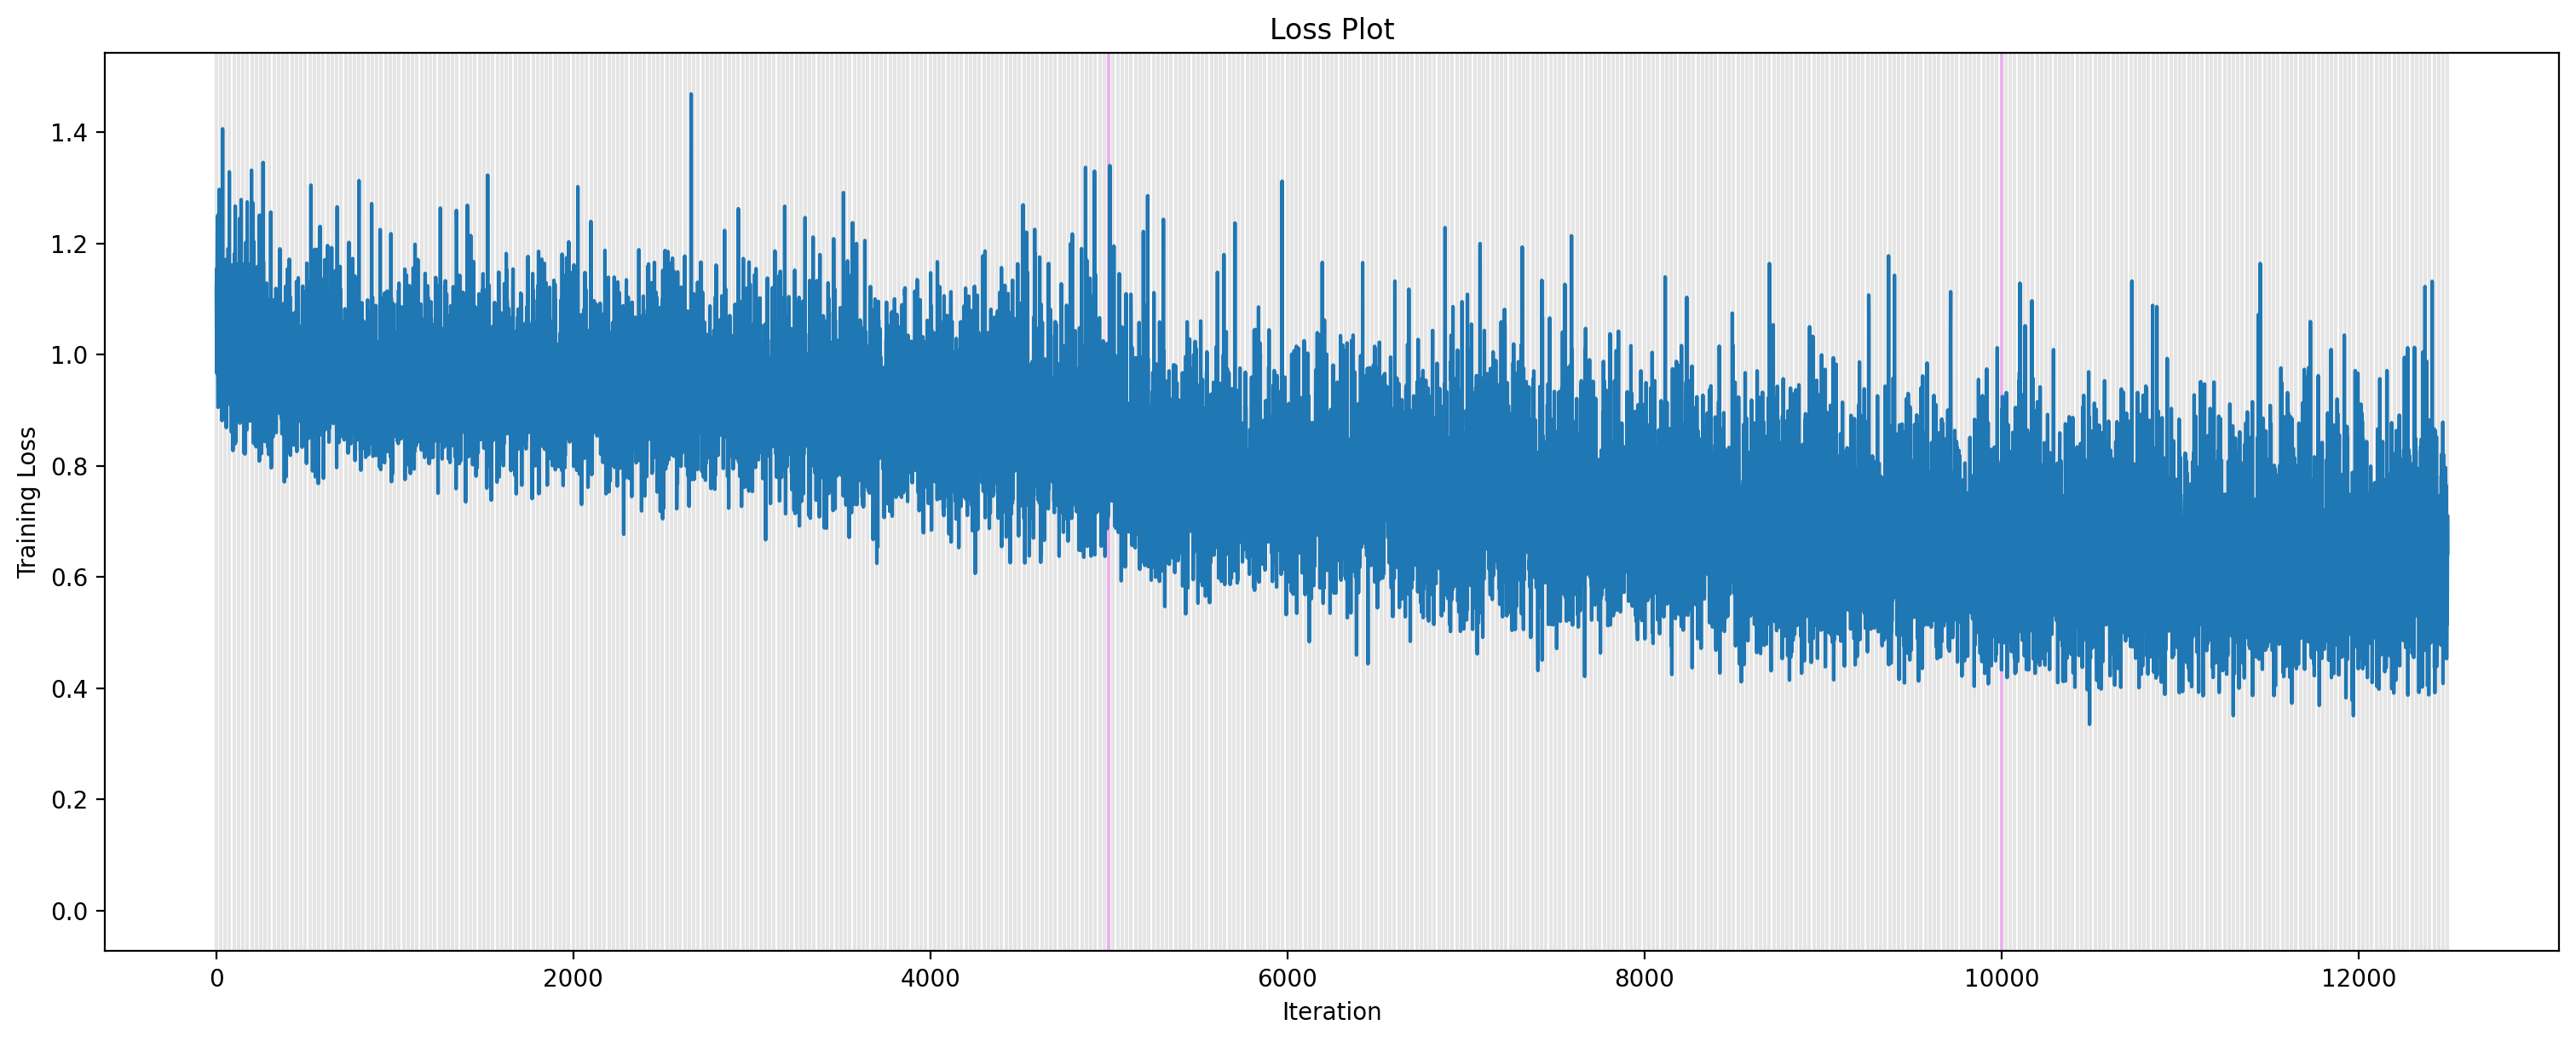

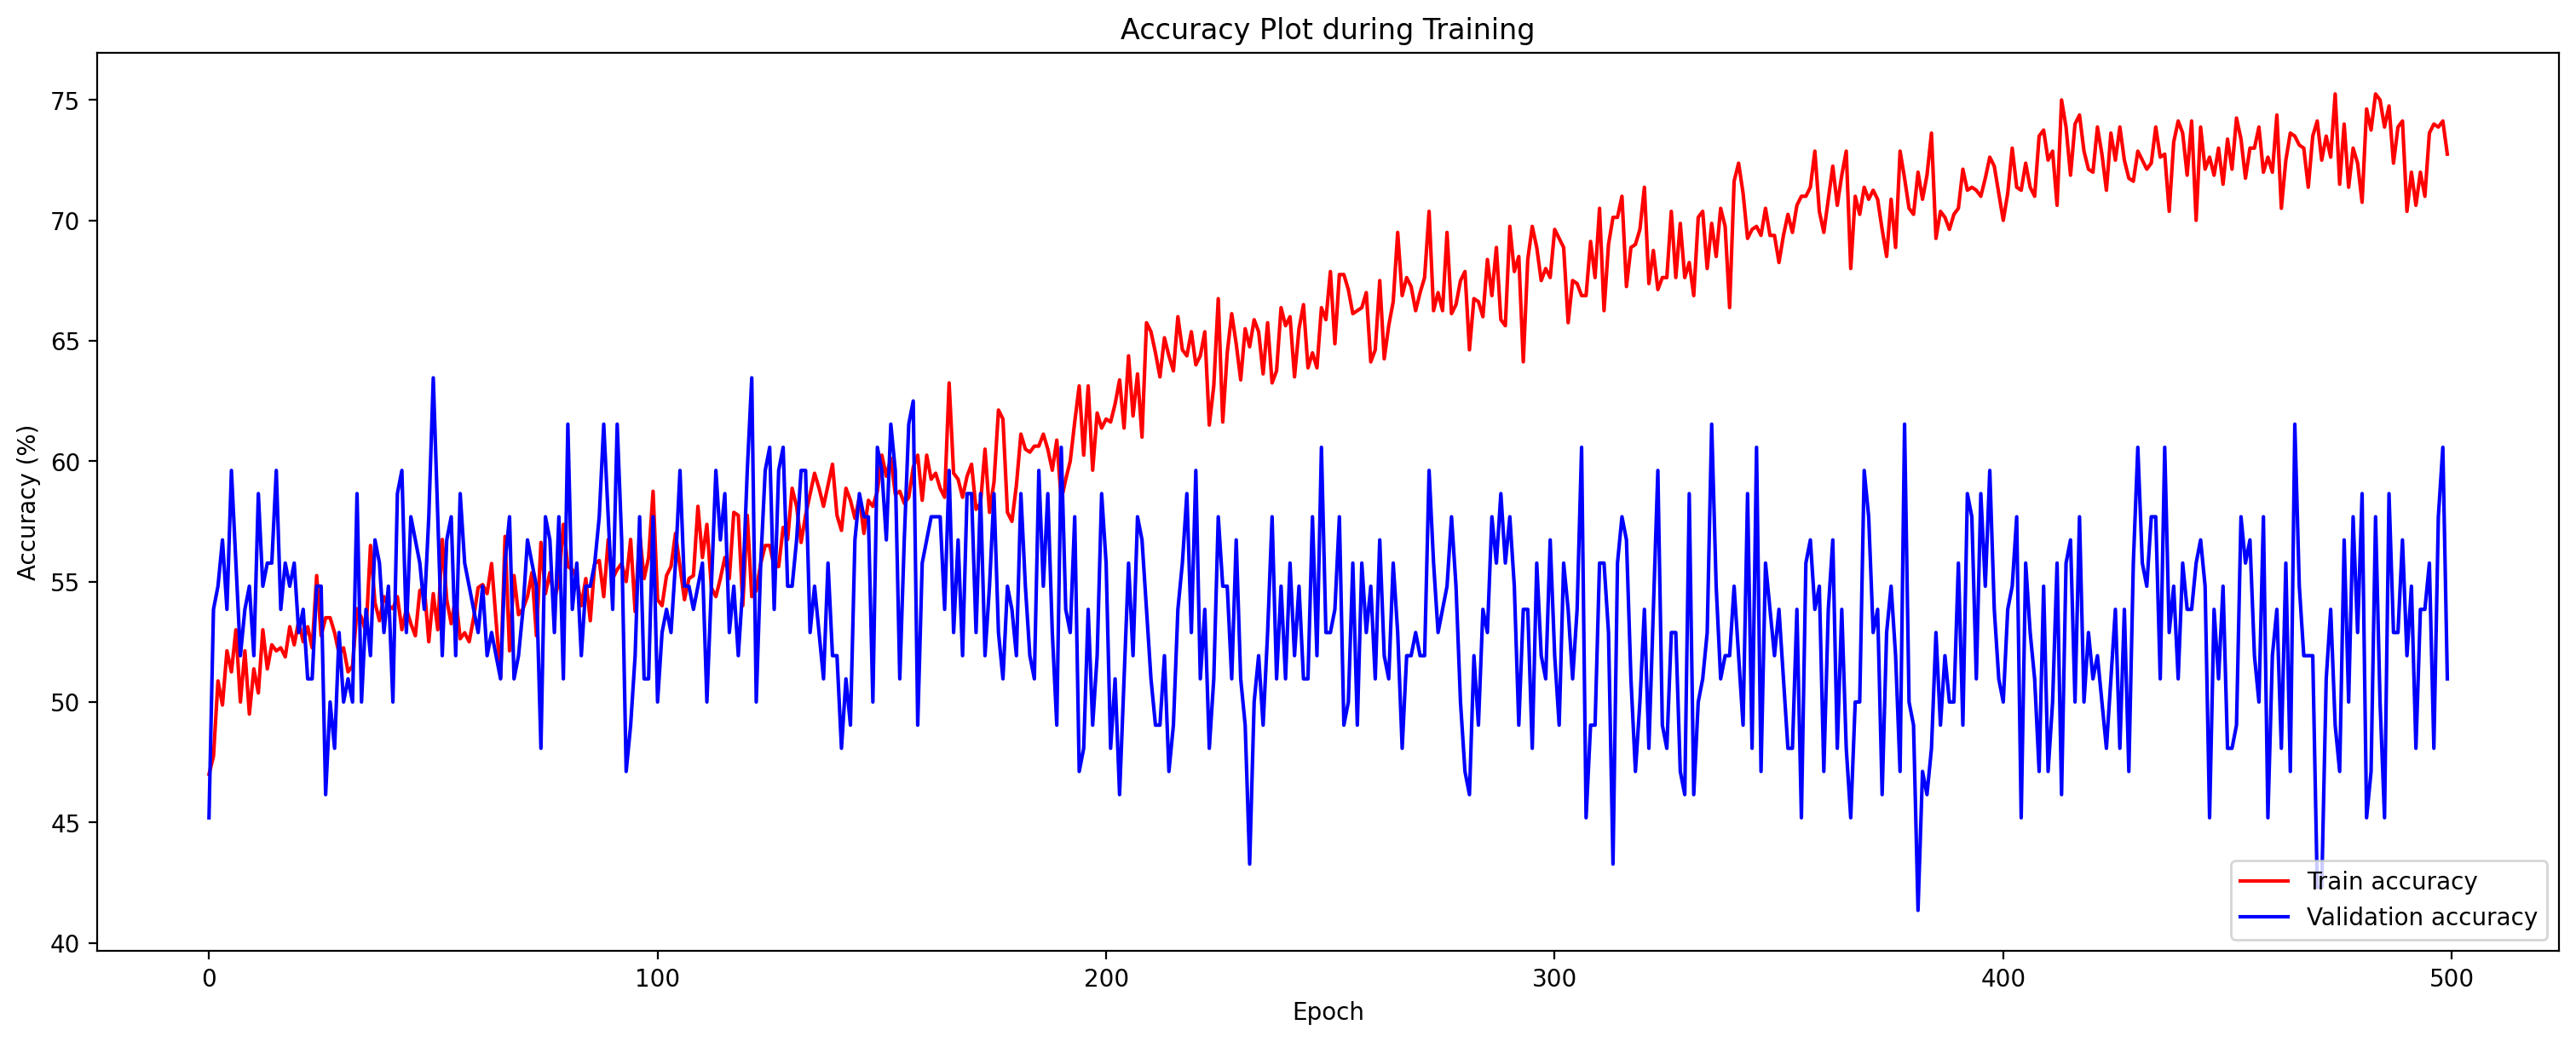

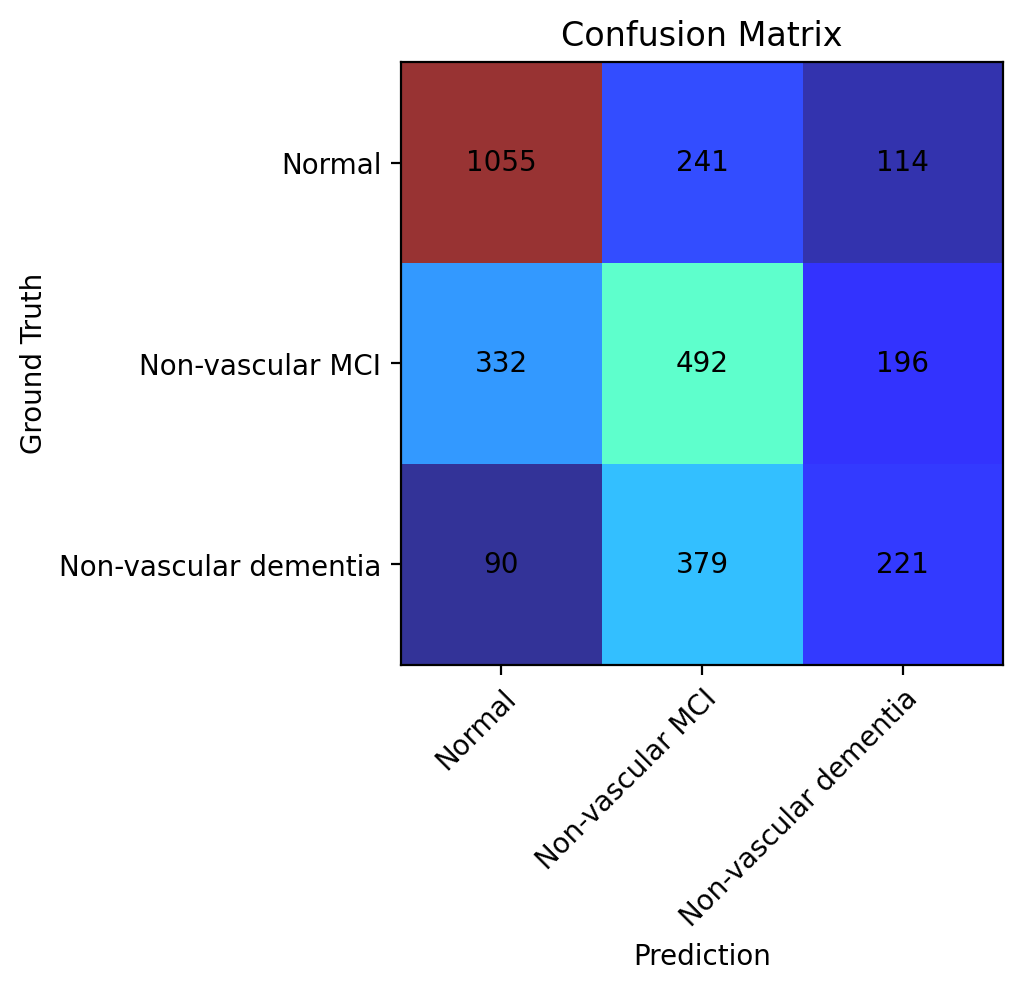

In [24]:
# reduce the learning after [lr_schedule_step] epochs by a factor of 10
n_epoch = 500
lr_schedule_step = 200
log_interval = len(train_loader) // 2

loss_history = []
train_acc_history = []
val_acc_history = []

model.reset_weights()
optimizer = optim.AdamW(model.parameters(), lr=10 ** best_log_lr, weight_decay=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=lr_schedule_step, gamma=0.1)

print(f'{"*"*40} Training Starts {"*"*40}')

for epoch in tqdm(range(1, n_epoch + 1)):
    print(f'{"-"*30} Epoch {epoch:03d} / {n_epoch:03d}, Learning rate: {optimizer.param_groups[-1]["lr"]:.2e} {"-"*30}')
    
    # train
    loss, train_accuracy, train_confusion = train_one_epoch(model, optimizer, log_interval)
    loss_history.extend(loss)
    train_acc_history.append(train_accuracy)
    
    # validation
    val_accuracy, val_confusion = check_val_accuracy(model)
    val_acc_history.append(val_accuracy)
    
    # learning rate schedule
    scheduler.step()
    
    print()
    print(f'* Train accuracy / confusion: {train_accuracy:.2f}% / {train_confusion.tolist()}, ')
    print(f'* Val   accuracy / confusion: {val_accuracy:.2f}% / {val_confusion.tolist()}')
    print()
    
    
# test
test_accuracy, test_confusion, test_debug = check_test_accuracy(model, repeat=30)

print(f'{"*"*40} Training Ends {"*"*40}')
print(f'- Test accuracy: {test_accuracy:.2f}%')
print()
print('- Confusion matrix:\n', test_confusion)
print()

# draw the training loss plot
draw_loss_plot(loss_history)
draw_accuracy_history(train_acc_history, val_acc_history)

# draw the confusion matrix
draw_confusion(test_confusion)

In [ ]:
print('- Debug table:')
pprint.pp(test_debug, indent=2, width=100)

#### 1D CNN: Siamese model2

In [25]:
class SiameseNet2(nn.Module):
    def __init__(self, n_input=20, n_output=3, n_channel=64,
                 use_age=True, final_pool='average'):
        super().__init__()
        
        if final_pool not in {'average', 'max'}:
            raise ValueError("final_pool must be set to one of ['average', 'max']")
        
        self.use_age = use_age
        
        self.conv1 = nn.Conv1d(n_input, n_channel, kernel_size=25, dilation=2, stride=3)
        self.bn1 = nn.BatchNorm1d(n_channel)
        self.pool1 = nn.MaxPool1d(3)
        
        self.conv2 = nn.Conv1d(n_channel, n_channel, kernel_size=7)
        self.bn2 = nn.BatchNorm1d(n_channel)
        self.pool2 = nn.MaxPool1d(2)
        
        self.conv3 = nn.Conv1d(n_channel, n_channel, kernel_size=7)
        self.bn3 = nn.BatchNorm1d(n_channel)
        self.pool3 = nn.MaxPool1d(2)
        
        self.conv4 = nn.Conv1d(n_channel, n_channel*2, kernel_size=7)
        self.bn4 = nn.BatchNorm1d(n_channel*2)
        
        if final_pool == 'average':
            self.final_pool = nn.AdaptiveAvgPool1d(1)
        elif final_pool == 'max':
            self.final_pool = nn.AdaptiveMaxPool1d(1)

        if self.use_age:        
            self.fc1_1 = nn.Linear(n_channel*2 + 1, n_channel)
            self.fc1_2 = nn.Linear(n_channel*2 + 1, n_channel)
        else:
            self.fc1_1 = nn.Linear(n_channel*2, n_channel)
            self.fc1_2 = nn.Linear(n_channel*2, n_channel)
        self.bnfc1_1 = nn.BatchNorm1d(n_channel)
        self.bnfc1_2 = nn.BatchNorm1d(n_channel)
                        
        self.fc2 = nn.Linear(n_channel*2, n_channel)
        self.bnfc2 = nn.BatchNorm1d(n_channel)

        self.fc3 = nn.Linear(n_channel, n_channel//2)
        self.bnfc3 = nn.BatchNorm1d(n_channel//2)
        
        self.fc4 = nn.Linear(n_channel//2, n_output)
        
    def reset_weights(self):
        for m in self.modules():
            if hasattr(m, 'reset_parameters'):
                m.reset_parameters()

    def forward(self, x, age, print_shape=False):
        # conv-bn-relu-pool 
        x = self.conv1(x)
        x = F.relu(self.bn1(x))
        x = self.pool1(x)

        x = self.conv2(x)
        x = F.relu(self.bn2(x))
        x = self.pool2(x)

        x = self.conv3(x)
        x = F.relu(self.bn3(x))
        x = self.pool3(x)

        x = self.conv4(x)
        x = F.relu(self.bn4(x))

        if print_shape:
            print('Shape right before squeezing:', x.shape)
        
        L = x.shape[2]
        x1 = x[:, :, :L//2]
        x2 = x[:, :, L//2:]
        
        x1 = self.final_pool(x1).squeeze()
        x2 = self.final_pool(x2).squeeze()
        
        if self.use_age:
            x1 = torch.cat((x1, age.reshape(-1, 1)), dim=1)
            x2 = torch.cat((x2, age.reshape(-1, 1)), dim=1)

        # fc-bn-relu-fc
        x1 = self.fc1_1(x1)
        x1 = self.bnfc1_1(x1)
        x1 = F.relu(x1)
        
        x2 = self.fc1_2(x2)
        x2 = self.bnfc1_2(x2)
        x2 = F.relu(x2)
        
        x = torch.cat((x1, x2), dim=1)

        x = self.fc2(x)
        x = self.bnfc2(x)
        x = F.relu(x)

        x = self.fc3(x)
        x = self.bnfc3(x)
        x = F.relu(x)
        
        x = self.fc4(x)
        
        return x
        # return F.log_softmax(x, dim=1)

In [26]:
model = SiameseNet2(n_input=train_dataset[0]['signal'].shape[0], 
                    n_output=3, 
                    use_age=True, 
                    final_pool='average')

model = model.to(device, dtype=torch.float32)
print(model)
print()

# tensorboard visualization
visualize_network_tensorboard(model, 'SiameseNet_2')

# number of parameters
n = count_parameters(model)
print(f'The Number of parameters of the model: {n:,}')

SiameseNet2(
  (conv1): Conv1d(20, 64, kernel_size=(25,), stride=(3,), dilation=(2,))
  (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(64, 64, kernel_size=(7,), stride=(1,))
  (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv1d(64, 64, kernel_size=(7,), stride=(1,))
  (bn3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv1d(64, 128, kernel_size=(7,), stride=(1,))
  (bn4): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (final_pool): AdaptiveAvgPool1d(output_size=1)
  (fc1_1): Linear(in_features=129, out_features=64, bias=True)
  (fc1_2): Line

  0%|          | 0/500 [00:00<?, ?it/s]

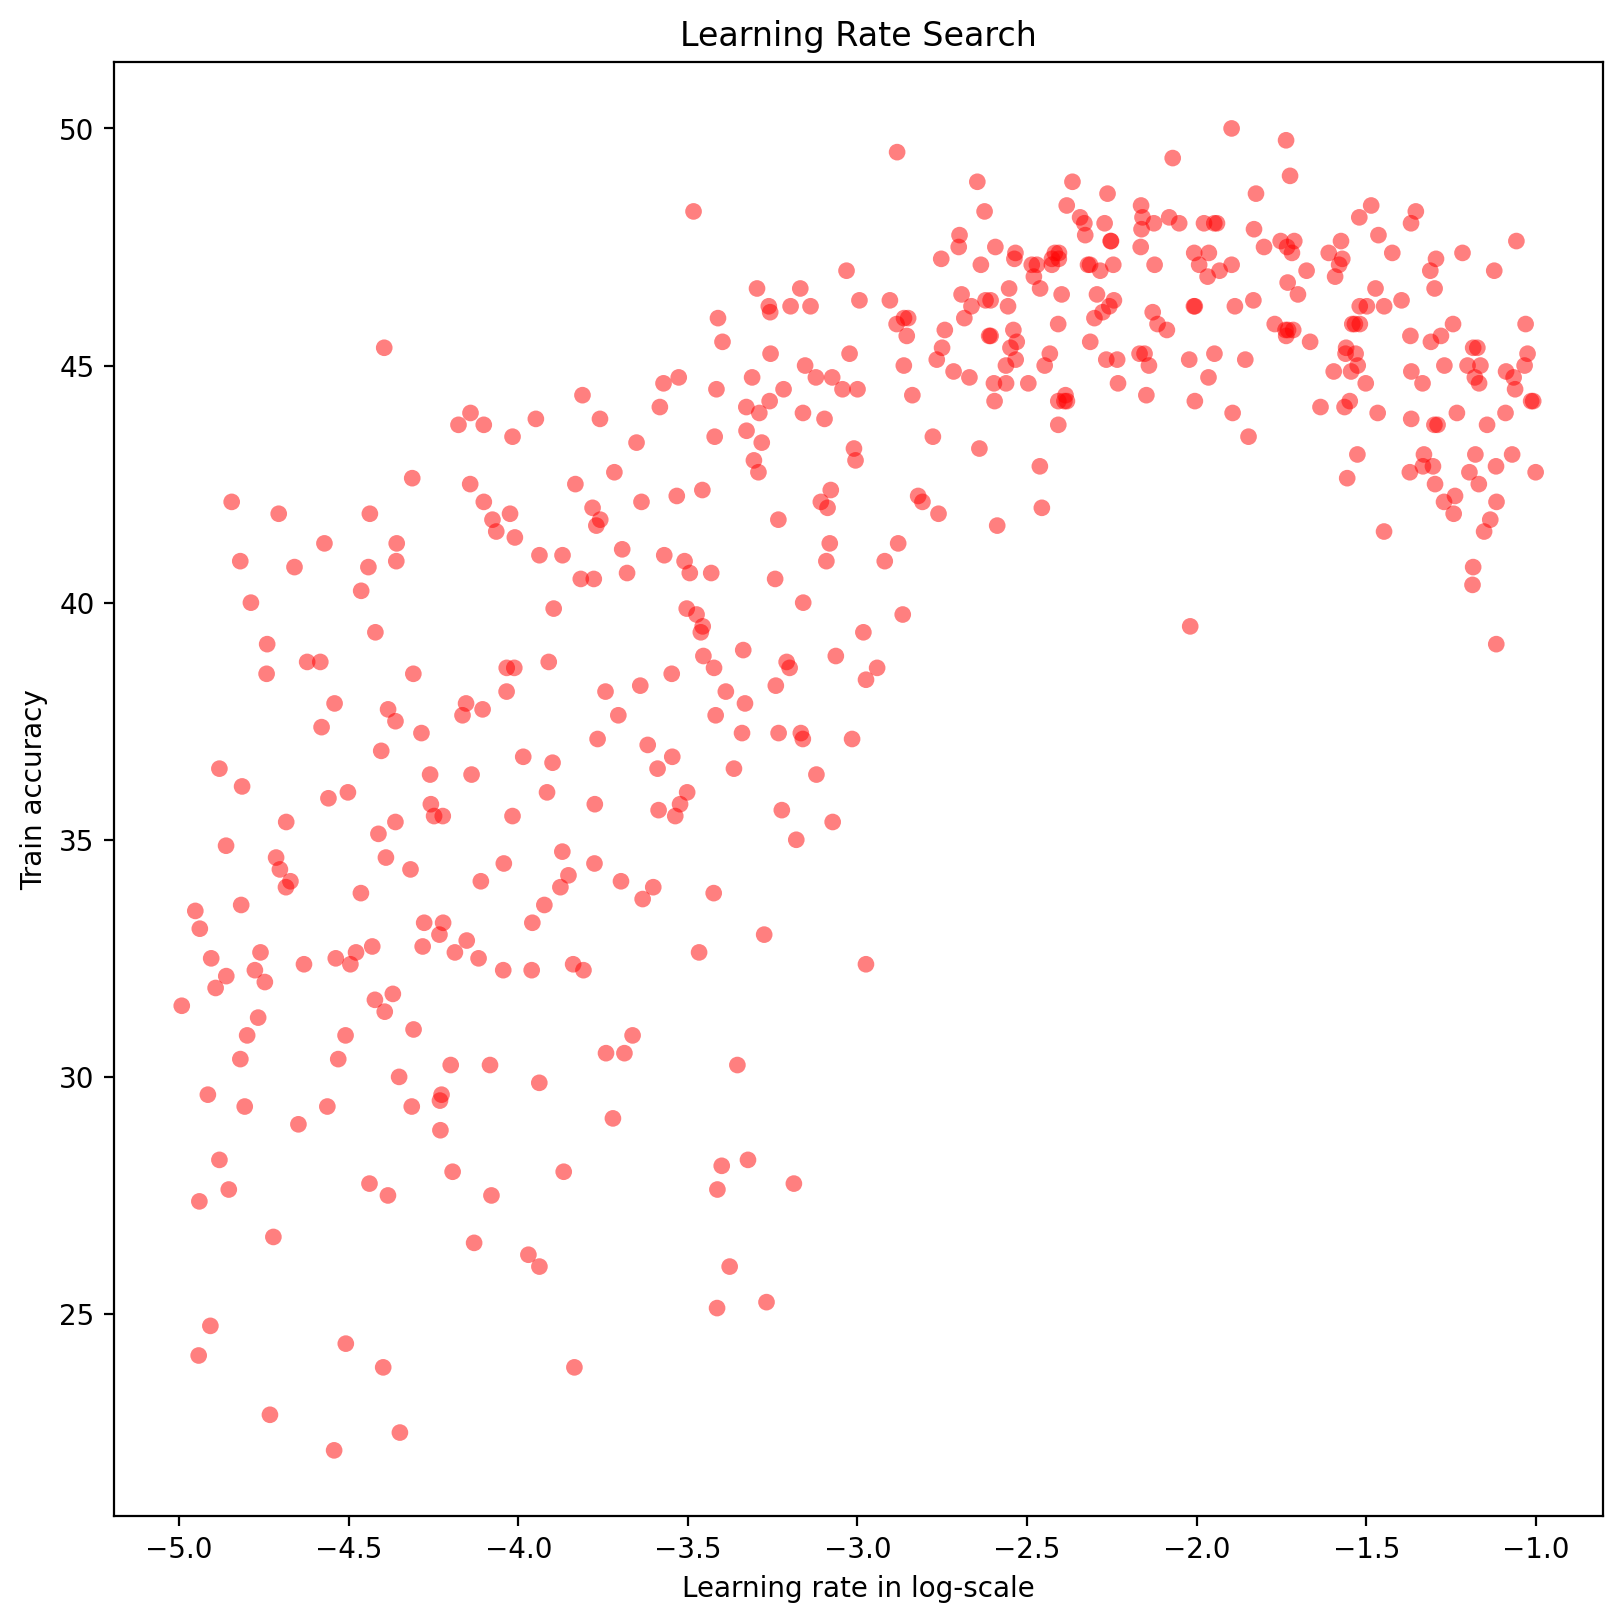

best_log_lr: -1.896920661598687


In [27]:
# record = learning_rate_search(model, 
#                               min_log_lr=-4.5, 
#                               max_log_lr=-1.4, 
#                               trials=500, 
#                               epochs=1)
# draw_learning_rate_record(record)
# best_log_lr = record[np.argmax(np.array([v for lr, v in record]))][0]

best_log_lr = -1.896920661598687
print('best_log_lr:', best_log_lr)

**************************************** Training Starts ****************************************


  0%|          | 0/500 [00:00<?, ?it/s]

------------------------------ Epoch 001 / 500, Learning rate: 1.27e-02 ------------------------------
- Iter 012 / 025, Loss: 0.909589
- Iter 024 / 025, Loss: 0.926088

* Train accuracy / confusion: 48.00% / [[286, 60, 12], [171, 85, 13], [89, 71, 13]], 
* Val   accuracy / confusion: 53.85% / [[30, 16, 0], [8, 26, 1], [7, 16, 0]]

------------------------------ Epoch 002 / 500, Learning rate: 1.27e-02 ------------------------------
- Iter 012 / 025, Loss: 0.978735
- Iter 024 / 025, Loss: 0.965940

* Train accuracy / confusion: 48.88% / [[270, 74, 14], [138, 109, 17], [75, 91, 12]], 
* Val   accuracy / confusion: 57.69% / [[34, 12, 0], [9, 26, 0], [7, 16, 0]]

------------------------------ Epoch 003 / 500, Learning rate: 1.27e-02 ------------------------------
- Iter 012 / 025, Loss: 1.005461
- Iter 024 / 025, Loss: 0.927581

* Train accuracy / confusion: 51.25% / [[252, 99, 3], [114, 149, 8], [58, 108, 9]], 
* Val   accuracy / confusion: 56.73% / [[34, 12, 0], [9, 25, 1], [9, 14, 0]]

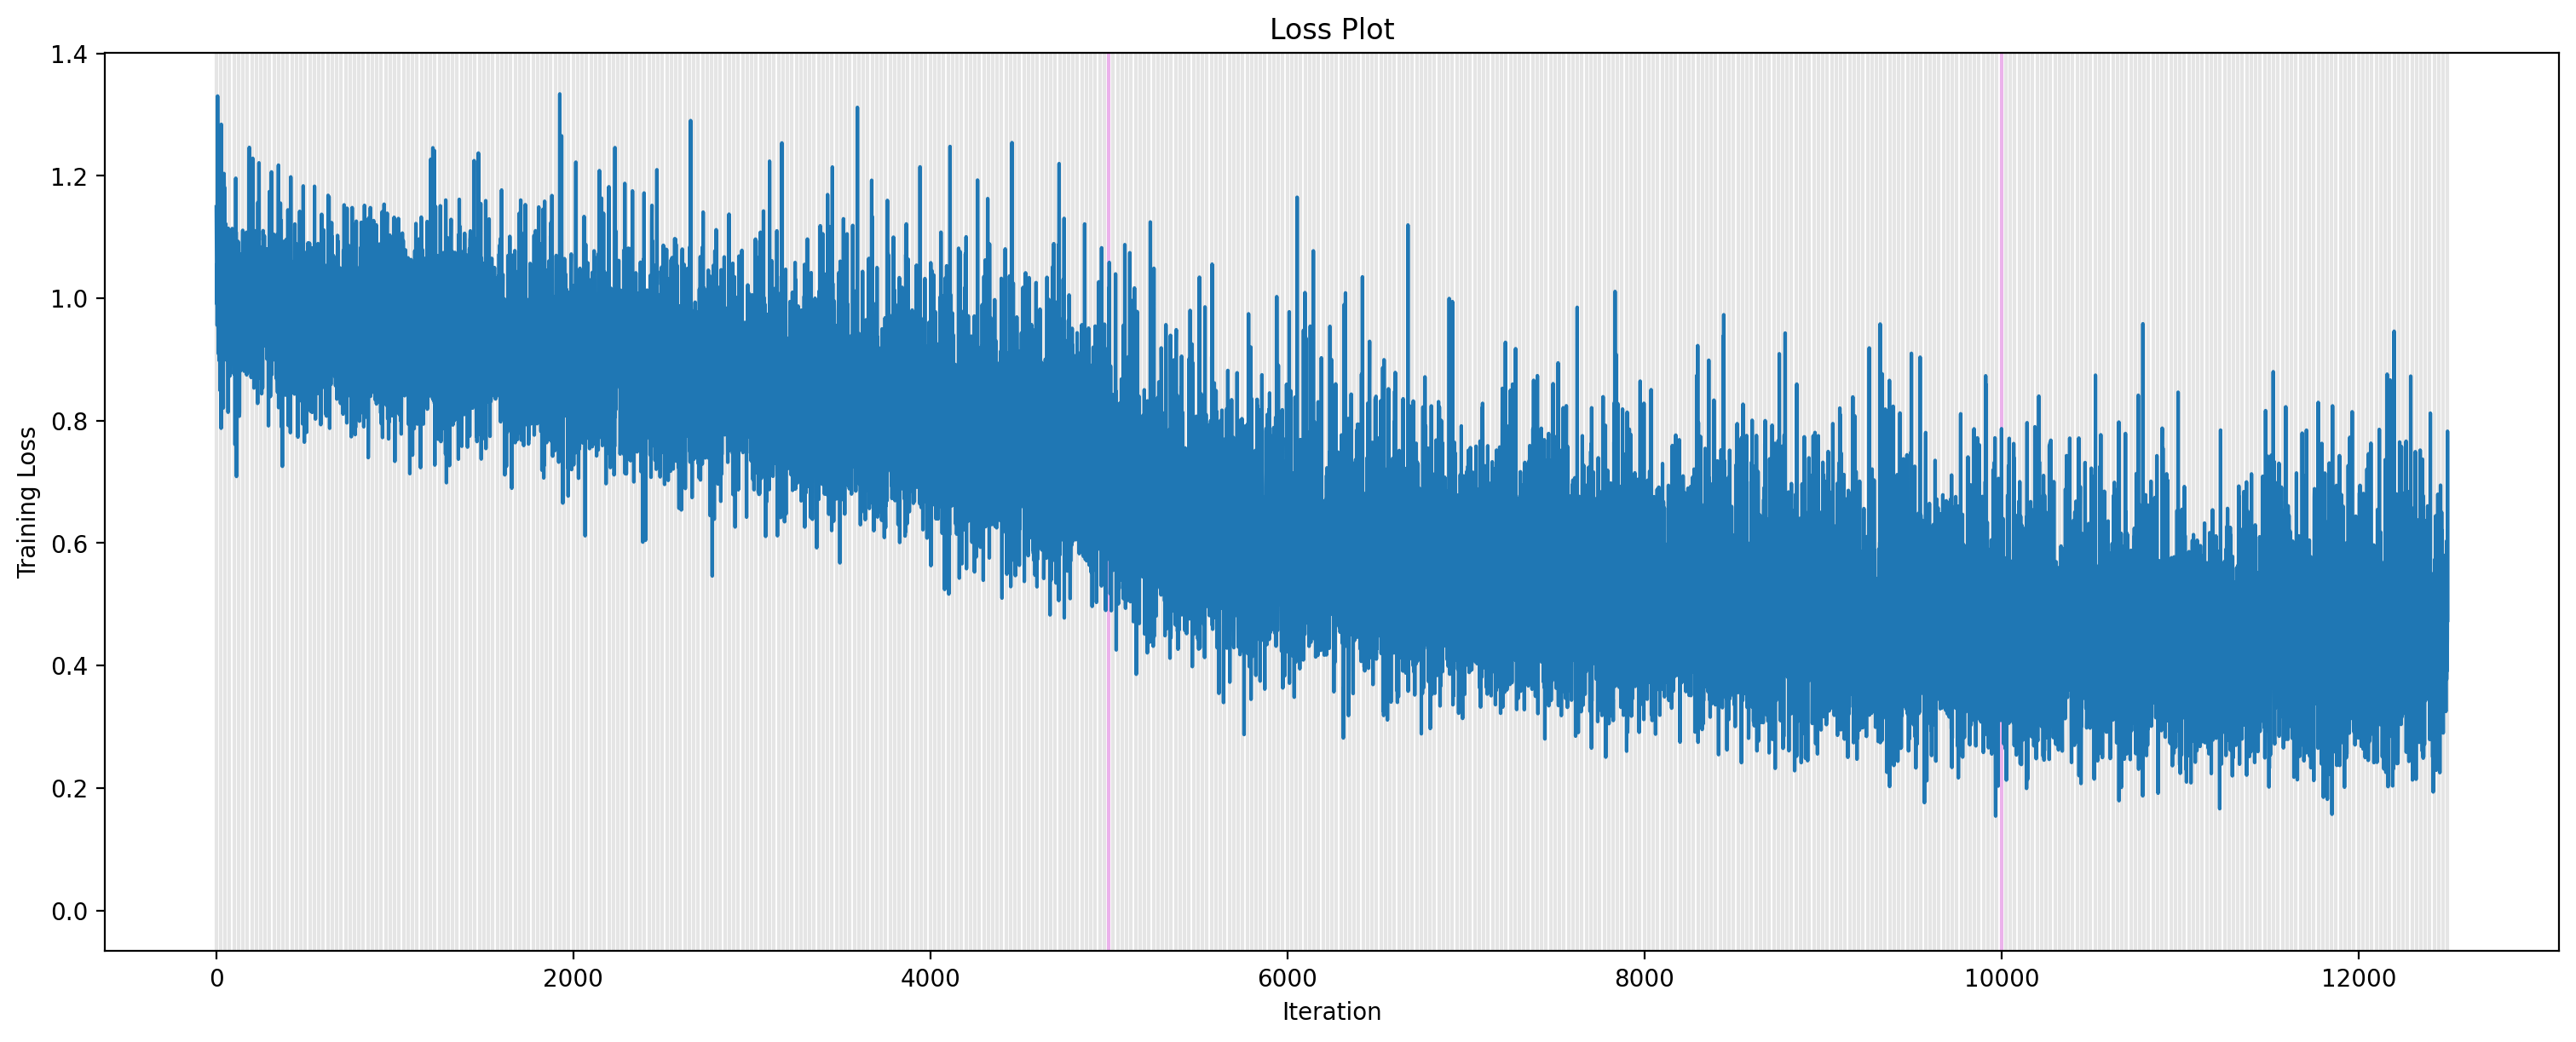

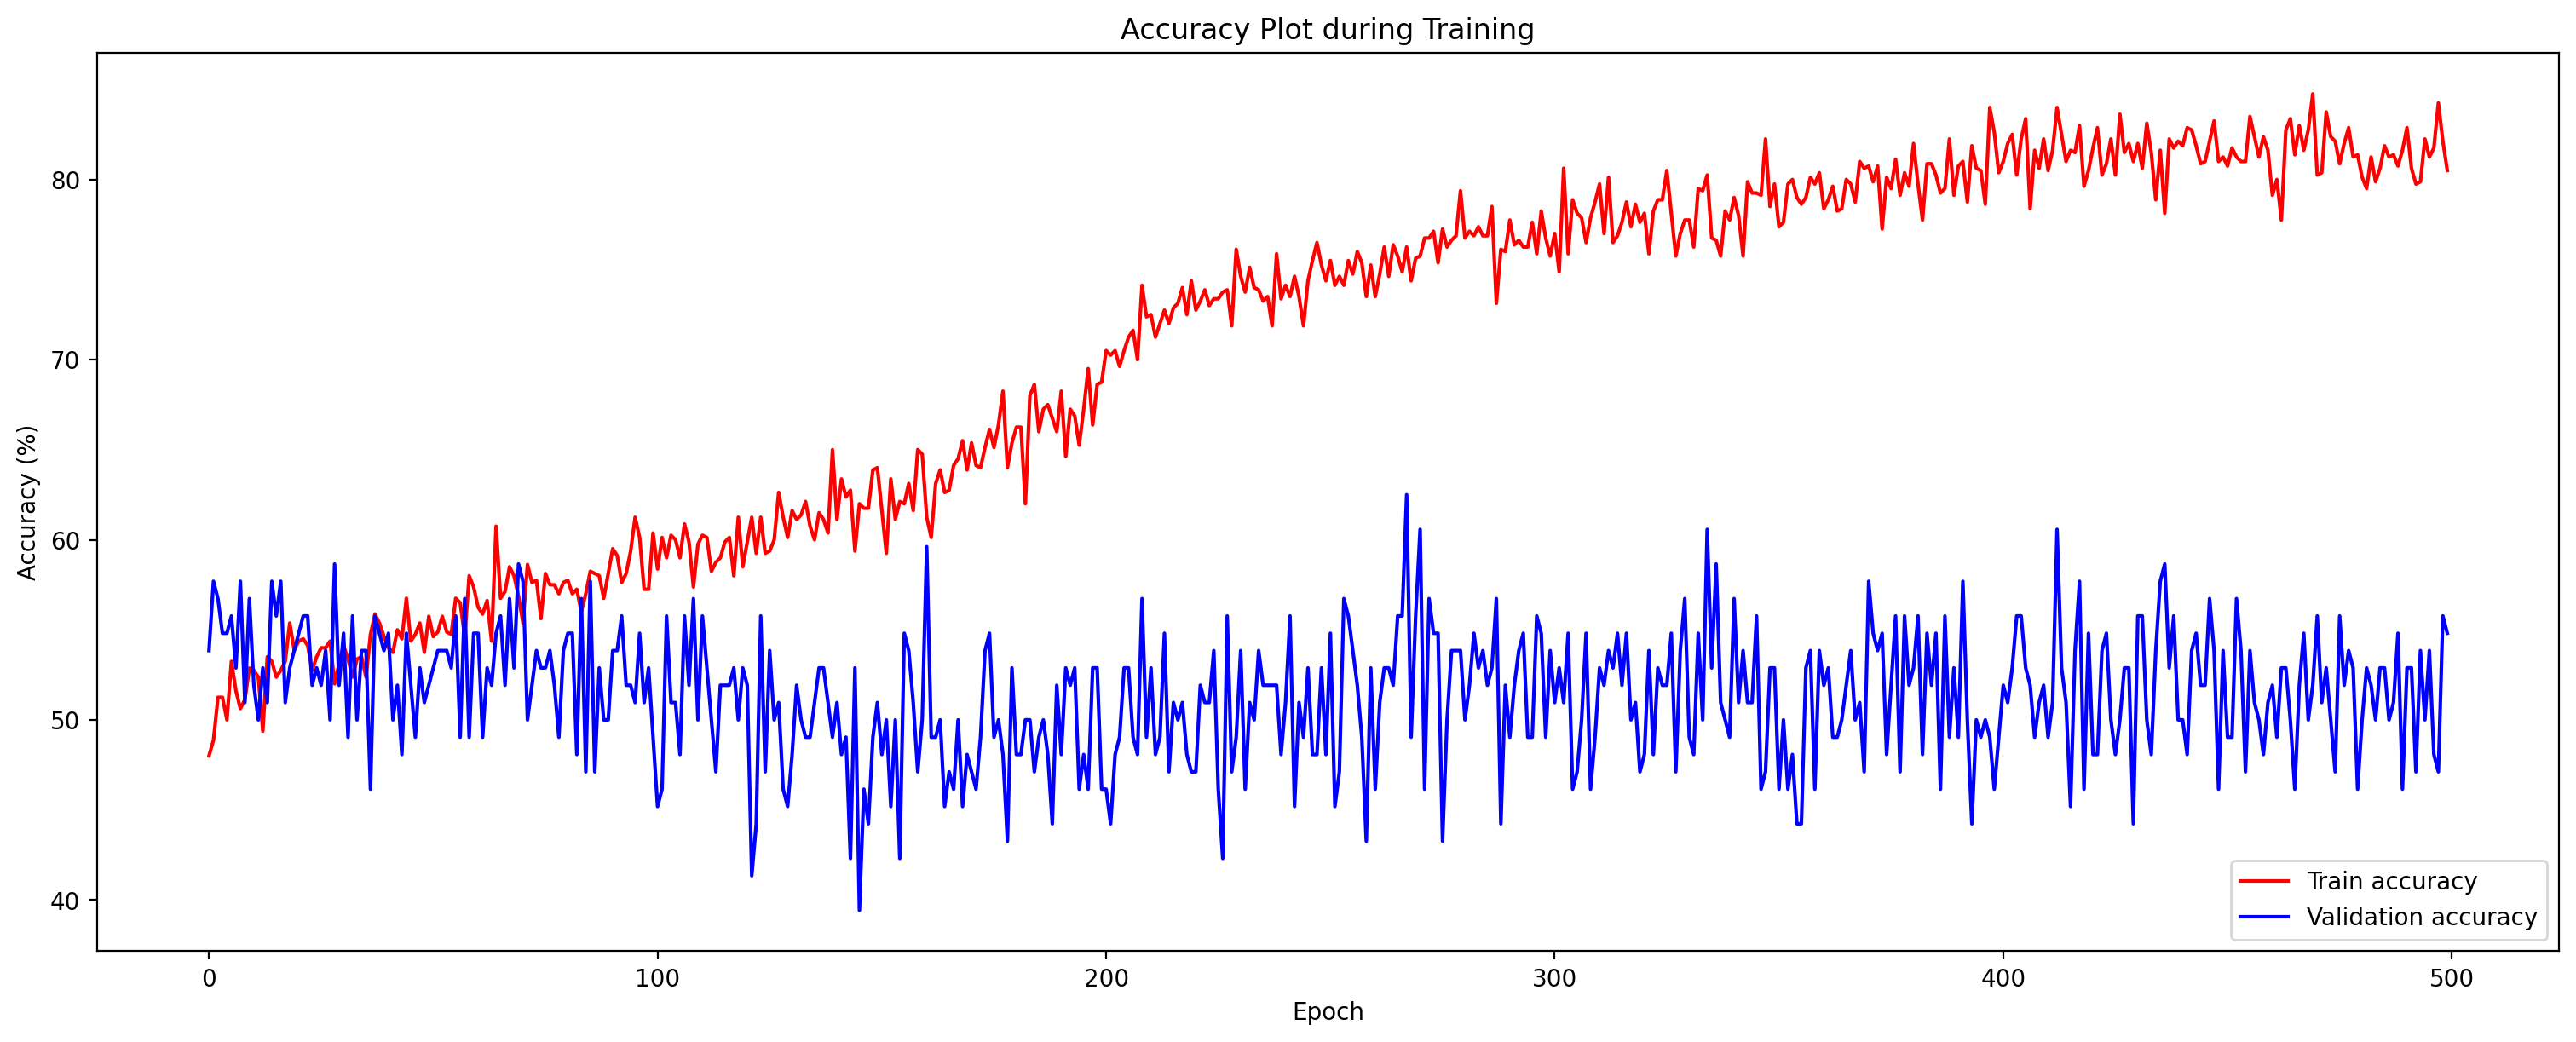

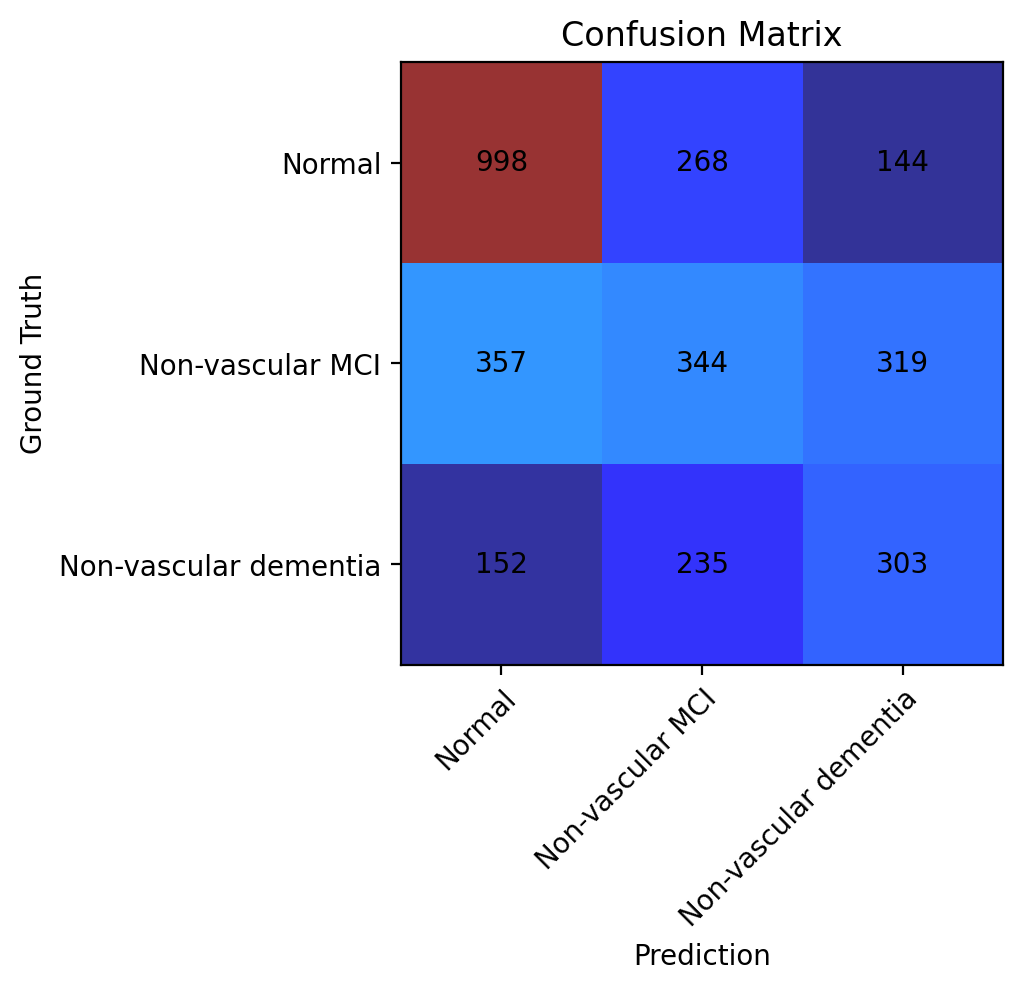

In [28]:
# reduce the learning after [lr_schedule_step] epochs by a factor of 10
n_epoch = 500
lr_schedule_step = 200
log_interval = len(train_loader) // 2

loss_history = []
train_acc_history = []
val_acc_history = []

model.reset_weights()
optimizer = optim.AdamW(model.parameters(), lr=10 ** best_log_lr, weight_decay=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=lr_schedule_step, gamma=0.1)

print(f'{"*"*40} Training Starts {"*"*40}')

for epoch in tqdm(range(1, n_epoch + 1)):
    print(f'{"-"*30} Epoch {epoch:03d} / {n_epoch:03d}, Learning rate: {optimizer.param_groups[-1]["lr"]:.2e} {"-"*30}')
    
    # train
    loss, train_accuracy, train_confusion = train_one_epoch(model, optimizer, log_interval)
    loss_history.extend(loss)
    train_acc_history.append(train_accuracy)
    
    # validation
    val_accuracy, val_confusion = check_val_accuracy(model)
    val_acc_history.append(val_accuracy)
    
    # learning rate schedule
    scheduler.step()
    
    print()
    print(f'* Train accuracy / confusion: {train_accuracy:.2f}% / {train_confusion.tolist()}, ')
    print(f'* Val   accuracy / confusion: {val_accuracy:.2f}% / {val_confusion.tolist()}')
    print()
    
# test
test_accuracy, test_confusion, test_debug = check_test_accuracy(model, repeat=30)

print(f'{"*"*40} Training Ends {"*"*40}')
print(f'- Test accuracy: {test_accuracy:.2f}%')
print()
print('- Confusion matrix:\n', test_confusion)
print()

# draw the training loss plot
draw_loss_plot(loss_history)
draw_accuracy_history(train_acc_history, val_acc_history)

# draw the confusion matrix
draw_confusion(test_confusion)

In [ ]:
print('- Debug table:')
pprint.pp(test_debug, indent=2, width=100)

#### 1D CNN: Siamese model3

In [29]:
class SiameseNet3(nn.Module):
    def __init__(self, n_input=20, n_output=3, n_channel=64,
                 use_age=True, final_pool='average'):
        super().__init__()
        
        if final_pool not in {'average', 'max'}:
            raise ValueError("final_pool must be set to one of ['average', 'max']")
        
        self.use_age = use_age
        
        self.conv1 = nn.Conv1d(n_input, n_channel, kernel_size=25, stride=2)
        self.bn1 = nn.BatchNorm1d(n_channel)
        self.pool1 = nn.MaxPool1d(2)
        
        self.conv2 = nn.Conv1d(n_channel, n_channel, kernel_size=7)
        self.bn2 = nn.BatchNorm1d(n_channel)
        self.pool2 = nn.MaxPool1d(2)
        
        self.conv3 = nn.Conv1d(n_channel, n_channel, kernel_size=7)
        self.bn3 = nn.BatchNorm1d(n_channel)
        self.pool3 = nn.MaxPool1d(2)
        
        self.conv4_1 = nn.Conv1d(n_channel, n_channel*2, kernel_size=9)
        self.bn4_1 = nn.BatchNorm1d(n_channel*2)

        self.conv4_2 = nn.Conv1d(n_channel, n_channel*2, kernel_size=9)
        self.bn4_2 = nn.BatchNorm1d(n_channel*2)

        self.conv5_1 = nn.Conv1d(n_channel*2, n_channel*2, kernel_size=7)
        self.bn5_1 = nn.BatchNorm1d(n_channel*2)

        self.conv5_2 = nn.Conv1d(n_channel*2, n_channel*2, kernel_size=7)
        self.bn5_2 = nn.BatchNorm1d(n_channel*2)
        
        if final_pool == 'average':
            self.final_pool = nn.AdaptiveAvgPool1d(1)
        elif final_pool == 'max':
            self.final_pool = nn.AdaptiveMaxPool1d(1)
            
        if self.use_age:        
            self.fc1 = nn.Linear(n_channel*2 + 1, n_channel)
        else:
            self.fc1 = nn.Linear(n_channel*2, n_channel)
            
        self.dropout = nn.Dropout(p=0.2)
        self.bnfc1 = nn.BatchNorm1d(n_channel)

        self.fc2 = nn.Linear(n_channel, n_channel//2)
        self.bnfc2 = nn.BatchNorm1d(n_channel//2)
        self.fc3 = nn.Linear(n_channel//2, n_output)
        
    def reset_weights(self):
        for m in self.modules():
            if hasattr(m, 'reset_parameters'):
                m.reset_parameters()

    def forward(self, x, age, print_shape=False):
        # conv-bn-relu-pool 
        x = self.conv1(x)
        x = F.relu(self.bn1(x))
        x = self.pool1(x)

        x = self.conv2(x)
        x = F.relu(self.bn2(x))
        x = self.pool2(x)

        x = self.conv3(x)
        x = F.relu(self.bn3(x))
        x = self.pool3(x)

        if print_shape:
            print('Shape right before squeezing:', x.shape)
        
        L = x.shape[2]
        x1 = x[:, :, :L//2]
        x2 = x[:, :, L//2:]
        
        x1 = self.conv4_1(x1)
        x1 = F.relu(self.bn4_1(x1))

        x2 = self.conv4_2(x2)
        x2 = F.relu(self.bn4_2(x2))
        
        x1 = self.conv5_1(x1)
        x1 = F.relu(self.bn5_1(x1))

        x2 = self.conv5_2(x2)
        x2 = F.relu(self.bn5_2(x2))
                
        x1 = self.final_pool(x1).squeeze()
        x2 = self.final_pool(x2).squeeze()

        x = x1 * x2
        x = x.reshape(x.shape[0], -1) # (N, C, 1) -> (N, C)
        if self.use_age:
            x = torch.cat((x, age.reshape(-1, 1)), dim=1)

        # fc-bn-dropout-relu-fc
        x = self.fc1(x)
        x = self.bnfc1(x)
        x = self.dropout(x)
        x = F.relu(x)
        
        x = self.fc2(x)
        x = self.bnfc2(x)
        x = F.relu(x)
        
        x = self.fc3(x)
        
        return x
        # return F.log_softmax(x, dim=1)

In [30]:
model = SiameseNet3(n_input=train_dataset[0]['signal'].shape[0], 
                    n_output=3, 
                    use_age=True, 
                    final_pool='max')

model = model.to(device, dtype=torch.float32)
print(model)
print()

# tensorboard visualization
visualize_network_tensorboard(model, 'SiameseNet_3')

# number of parameters
n = count_parameters(model)
print(f'The Number of parameters of the model: {n:,}')

SiameseNet3(
  (conv1): Conv1d(20, 64, kernel_size=(25,), stride=(2,))
  (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(64, 64, kernel_size=(7,), stride=(1,))
  (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv1d(64, 64, kernel_size=(7,), stride=(1,))
  (bn3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4_1): Conv1d(64, 128, kernel_size=(9,), stride=(1,))
  (bn4_1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4_2): Conv1d(64, 128, kernel_size=(9,), stride=(1,))
  (bn4_2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_runnin

  0%|          | 0/500 [00:00<?, ?it/s]

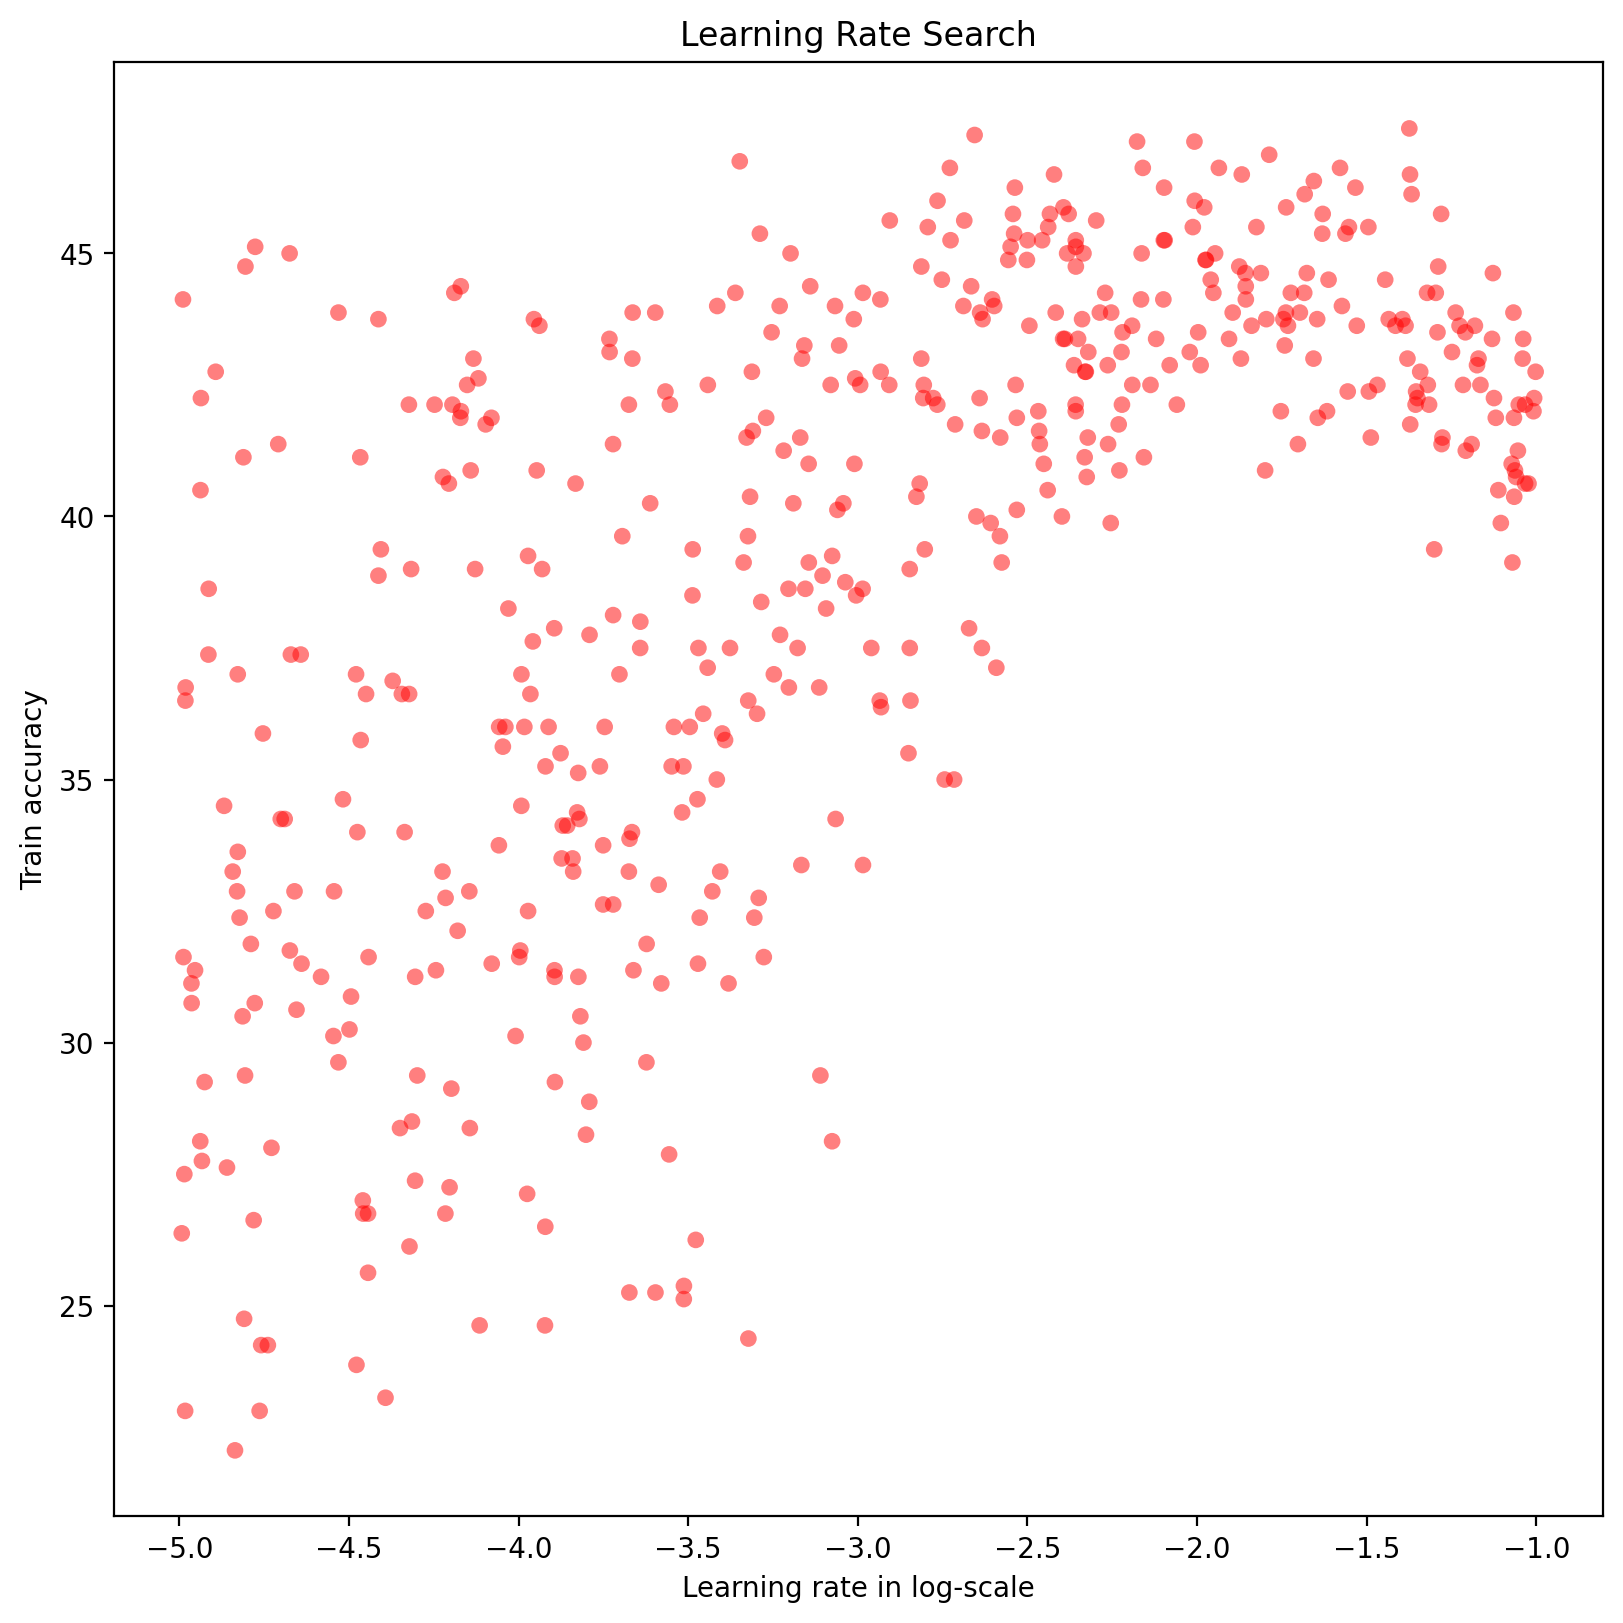

best_log_lr: -1.3743893054080911


In [31]:
# record = learning_rate_search(model, 
#                               min_log_lr=-4.5, 
#                               max_log_lr=-1.4, 
#                               trials=500, 
#                               epochs=1)
# draw_learning_rate_record(record)
# best_log_lr = record[np.argmax(np.array([v for lr, v in record]))][0]

best_log_lr = -1.5
print('best_log_lr:', best_log_lr)

**************************************** Training Starts ****************************************


  0%|          | 0/500 [00:00<?, ?it/s]

------------------------------ Epoch 001 / 500, Learning rate: 4.22e-02 ------------------------------
- Iter 012 / 025, Loss: 1.023928
- Iter 024 / 025, Loss: 1.030229

* Train accuracy / confusion: 43.00% / [[308, 35, 12], [225, 31, 11], [151, 22, 5]], 
* Val   accuracy / confusion: 40.38% / [[34, 12, 0], [27, 8, 0], [18, 5, 0]]

------------------------------ Epoch 002 / 500, Learning rate: 4.22e-02 ------------------------------
- Iter 012 / 025, Loss: 1.105547
- Iter 024 / 025, Loss: 1.012318

* Train accuracy / confusion: 46.50% / [[327, 23, 3], [225, 43, 4], [129, 44, 2]], 
* Val   accuracy / confusion: 48.08% / [[43, 3, 0], [28, 7, 0], [20, 3, 0]]

------------------------------ Epoch 003 / 500, Learning rate: 4.22e-02 ------------------------------
- Iter 012 / 025, Loss: 1.080527
- Iter 024 / 025, Loss: 1.019568

* Train accuracy / confusion: 47.62% / [[273, 75, 6], [164, 99, 6], [101, 67, 9]], 
* Val   accuracy / confusion: 56.73% / [[41, 5, 0], [17, 18, 0], [14, 9, 0]]

---

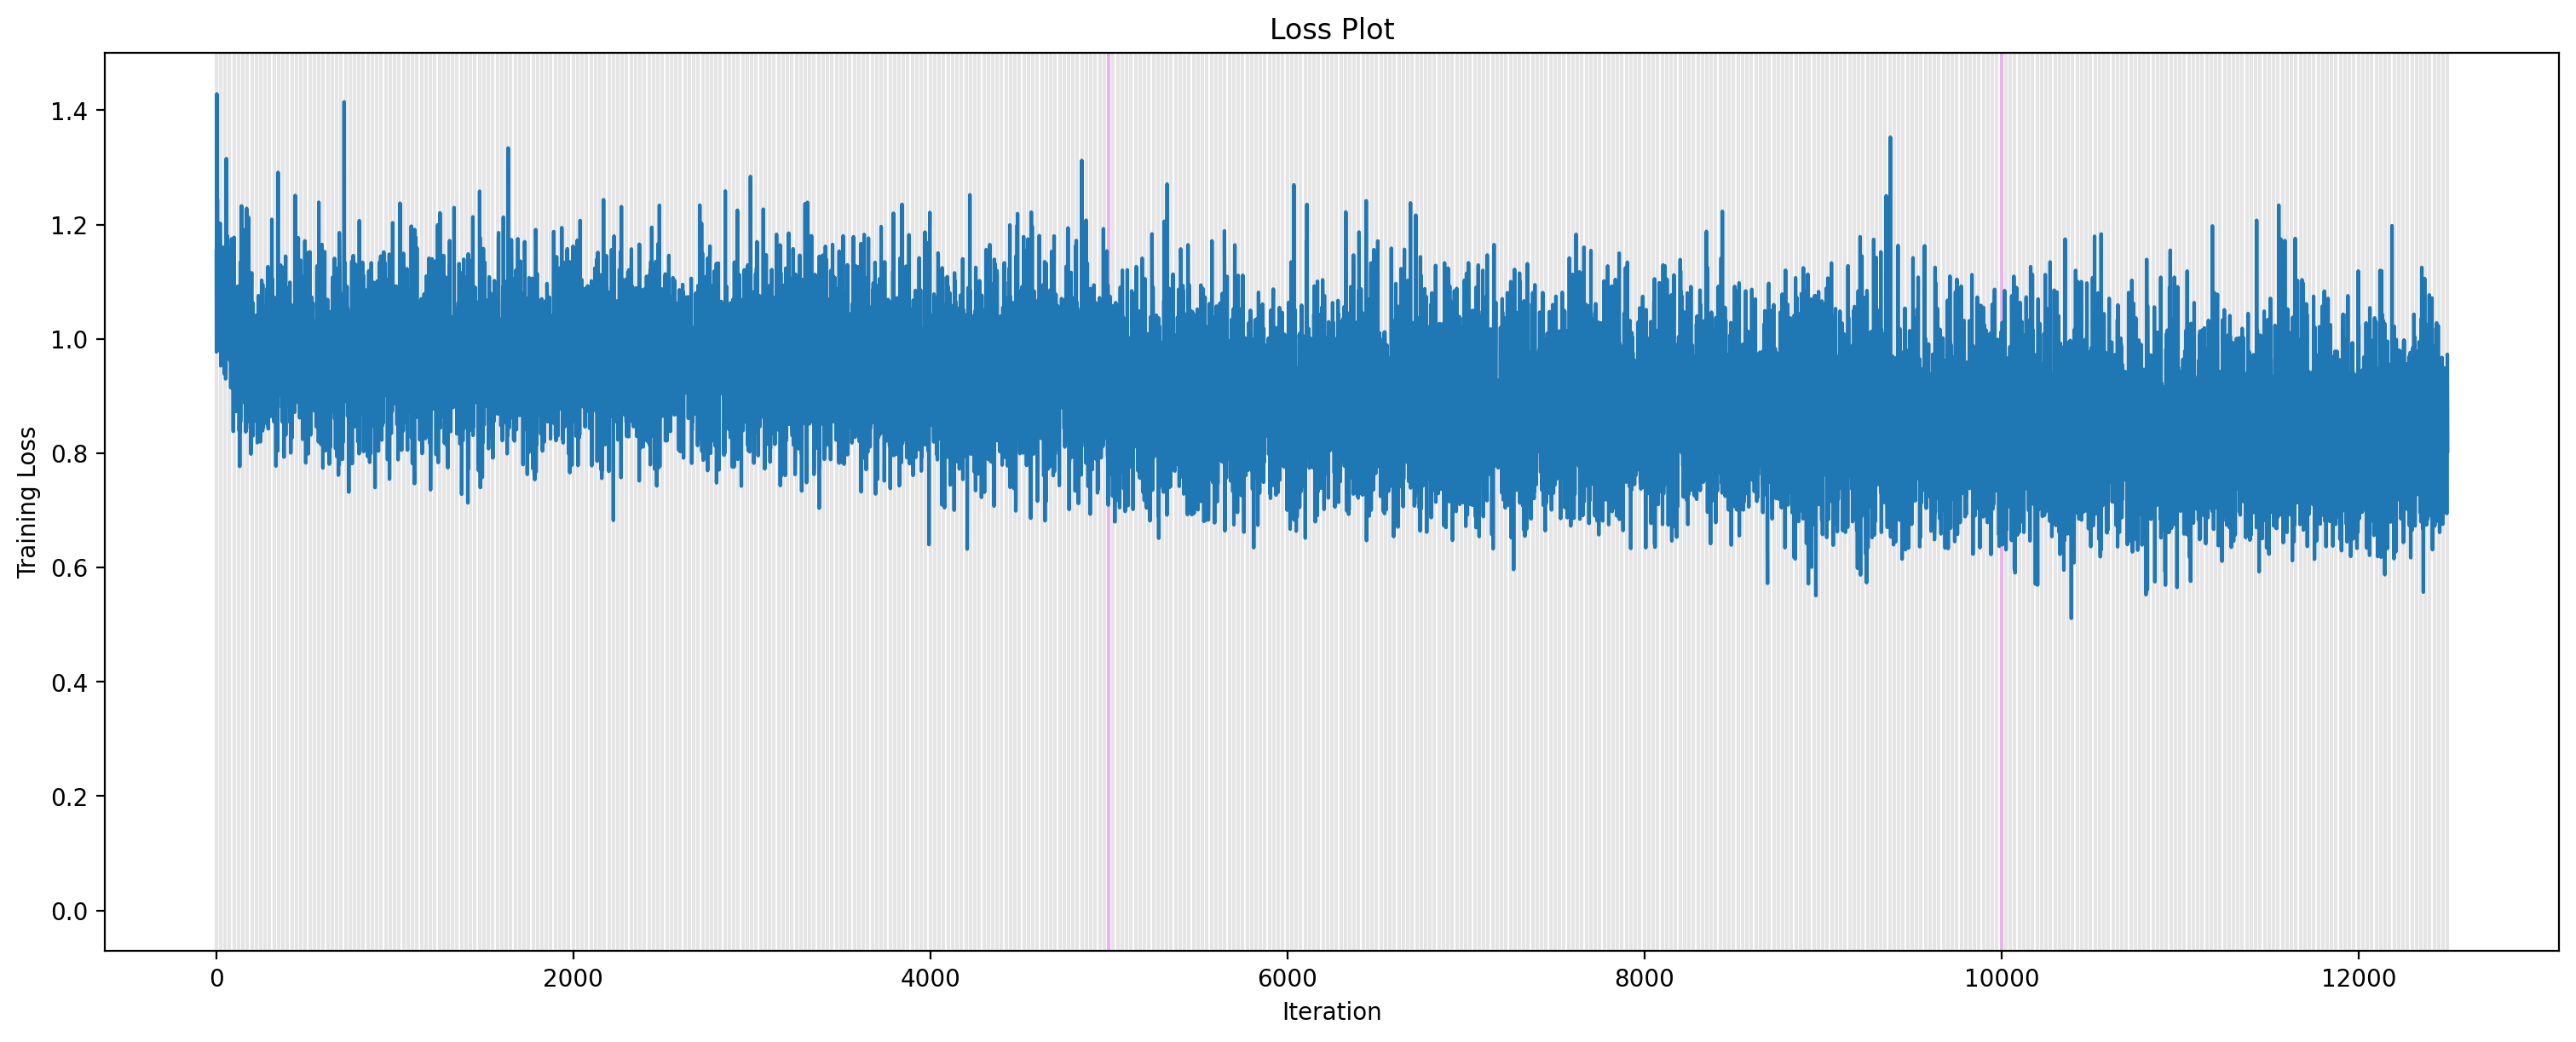

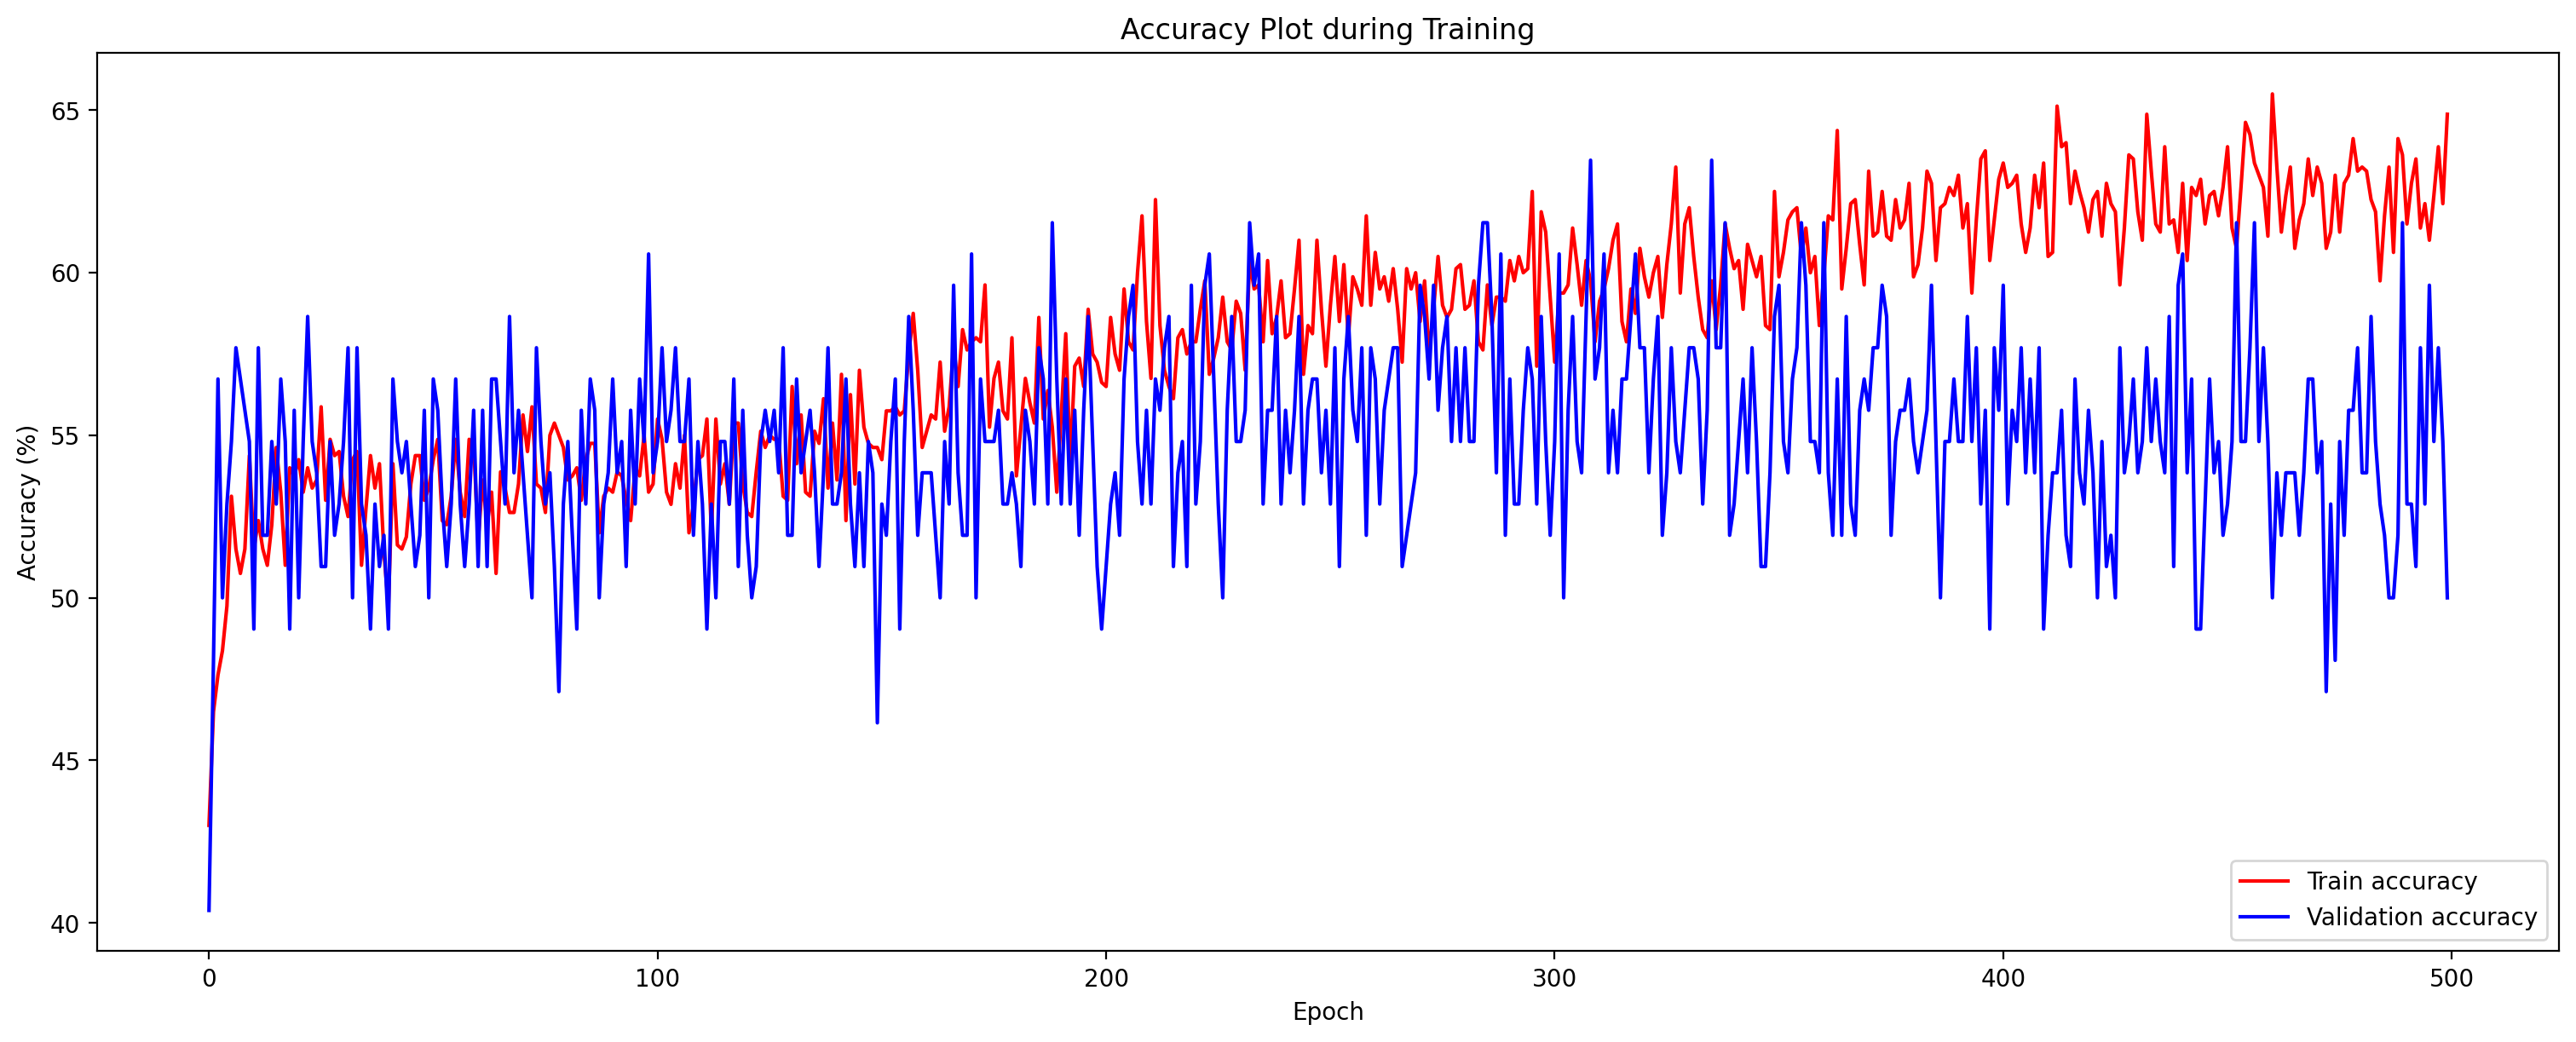

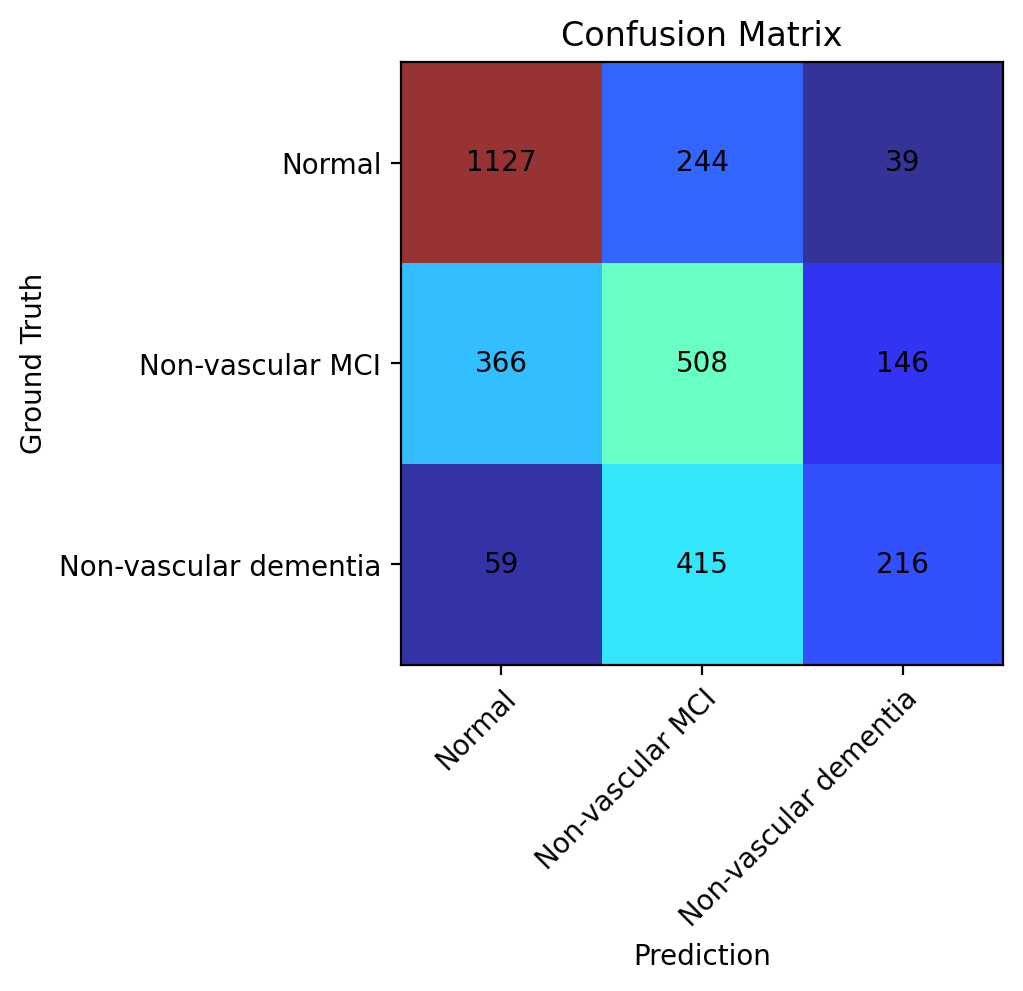

In [32]:
# reduce the learning after [lr_schedule_step] epochs by a factor of 10
n_epoch = 500
lr_schedule_step = 200
log_interval = len(train_loader) // 2

loss_history = []
train_acc_history = []
val_acc_history = []

model.reset_weights()
optimizer = optim.AdamW(model.parameters(), lr=10 ** best_log_lr, weight_decay=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=lr_schedule_step, gamma=0.1)

print(f'{"*"*40} Training Starts {"*"*40}')

for epoch in tqdm(range(1, n_epoch + 1)):
    print(f'{"-"*30} Epoch {epoch:03d} / {n_epoch:03d}, Learning rate: {optimizer.param_groups[-1]["lr"]:.2e} {"-"*30}')
    
    # train
    loss, train_accuracy, train_confusion = train_one_epoch(model, optimizer, log_interval)
    loss_history.extend(loss)
    train_acc_history.append(train_accuracy)
    
    # validation
    val_accuracy, val_confusion = check_val_accuracy(model)
    val_acc_history.append(val_accuracy)
    
    # learning rate schedule
    scheduler.step()
    
    print()
    print(f'* Train accuracy / confusion: {train_accuracy:.2f}% / {train_confusion.tolist()}, ')
    print(f'* Val   accuracy / confusion: {val_accuracy:.2f}% / {val_confusion.tolist()}')
    print()
    
# test
test_accuracy, test_confusion, test_debug = check_test_accuracy(model, repeat=30)

print(f'{"*"*40} Training Ends {"*"*40}')
print(f'- Test accuracy: {test_accuracy:.2f}%')
print()
print('- Confusion matrix:\n', test_confusion)
print()

# draw the training loss plot
draw_loss_plot(loss_history)
draw_accuracy_history(train_acc_history, val_acc_history)

# draw the confusion matrix
draw_confusion(test_confusion)

In [ ]:
print('- Debug table:')
pprint.pp(test_debug, indent=2, width=100)

#### 1D CNN: Siamese model4

In [33]:
class SiameseNet4(nn.Module):
    def __init__(self, n_input=20, n_output=3, n_channel=64,
                 use_age=True, final_pool='average'):
        super().__init__()
        
        if final_pool not in {'average', 'max'}:
            raise ValueError("final_pool must be set to one of ['average', 'max']")
        
        self.use_age = use_age
        
        self.conv1 = nn.Conv1d(n_input, n_channel, kernel_size=25, stride=2)
        self.bn1 = nn.BatchNorm1d(n_channel)
        self.pool1 = nn.MaxPool1d(2)
        
        self.conv2 = nn.Conv1d(n_channel, n_channel, kernel_size=7)
        self.bn2 = nn.BatchNorm1d(n_channel)
        self.pool2 = nn.MaxPool1d(2)
        
        self.conv3 = nn.Conv1d(n_channel, n_channel, kernel_size=7)
        self.bn3 = nn.BatchNorm1d(n_channel)
        self.pool3 = nn.MaxPool1d(2)
        
        self.conv4_1 = nn.Conv1d(n_channel, n_channel*2, kernel_size=9)
        self.bn4_1 = nn.BatchNorm1d(n_channel*2)

        self.conv4_2 = nn.Conv1d(n_channel, n_channel*2, kernel_size=9)
        self.bn4_2 = nn.BatchNorm1d(n_channel*2)

        self.conv5_1 = nn.Conv1d(n_channel*2, n_channel*2, kernel_size=7)
        self.bn5_1 = nn.BatchNorm1d(n_channel*2)

        self.conv5_2 = nn.Conv1d(n_channel*2, n_channel*2, kernel_size=7)
        self.bn5_2 = nn.BatchNorm1d(n_channel*2)
        
        if final_pool == 'average':
            self.final_pool = nn.AdaptiveAvgPool1d(1)
        elif final_pool == 'max':
            self.final_pool = nn.AdaptiveMaxPool1d(1)
            
        if self.use_age:        
            self.fc1 = nn.Linear(n_channel*4 + 1, n_channel)
        else:
            self.fc1 = nn.Linear(n_channel*4, n_channel)
            
        self.dropout = nn.Dropout(p=0.2)
        self.bnfc1 = nn.BatchNorm1d(n_channel)

        self.fc2 = nn.Linear(n_channel, n_channel//2)
        self.bnfc2 = nn.BatchNorm1d(n_channel//2)
        self.fc3 = nn.Linear(n_channel//2, n_output)
        
    def reset_weights(self):
        for m in self.modules():
            if hasattr(m, 'reset_parameters'):
                m.reset_parameters()

    def forward(self, x, age, print_shape=False):
        # conv-bn-relu-pool 
        x = self.conv1(x)
        x = F.relu(self.bn1(x))
        x = self.pool1(x)

        x = self.conv2(x)
        x = F.relu(self.bn2(x))
        x = self.pool2(x)

        x = self.conv3(x)
        x = F.relu(self.bn3(x))
        x = self.pool3(x)

        if print_shape:
            print('Shape right before squeezing:', x.shape)
        
        L = x.shape[2]
        x1 = x[:, :, :L//2]
        x2 = x[:, :, L//2:]
        
        x1 = self.conv4_1(x1)
        x1 = F.relu(self.bn4_1(x1))

        x2 = self.conv4_2(x2)
        x2 = F.relu(self.bn4_2(x2))
        
        x1 = self.conv5_1(x1)
        x1 = F.relu(self.bn5_1(x1))

        x2 = self.conv5_2(x2)
        x2 = F.relu(self.bn5_2(x2))
                
        x1 = self.final_pool(x1).squeeze()
        x2 = self.final_pool(x2).squeeze()

        x = torch.cat((x1, x2), dim=1)
        if self.use_age:
            x = torch.cat((x, age.reshape(-1, 1)), dim=1)

        # fc-bn-dropout-relu-fc
        x = self.fc1(x)
        x = self.bnfc1(x)
        x = self.dropout(x)
        x = F.relu(x)
        
        x = self.fc2(x)
        x = self.bnfc2(x)
        x = F.relu(x)
        
        x = self.fc3(x)
        
        return x
        # return F.log_softmax(x, dim=1)

In [34]:
model = SiameseNet4(n_input=train_dataset[0]['signal'].shape[0], 
                    n_output=3, 
                    use_age=True, 
                    final_pool='max')

model = model.to(device, dtype=torch.float32)
print(model)
print()

# tensorboard visualization
visualize_network_tensorboard(model, 'SiameseNet_3')

# number of parameters
n = count_parameters(model)
print(f'The Number of parameters of the model: {n:,}')

SiameseNet4(
  (conv1): Conv1d(20, 64, kernel_size=(25,), stride=(2,))
  (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(64, 64, kernel_size=(7,), stride=(1,))
  (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv1d(64, 64, kernel_size=(7,), stride=(1,))
  (bn3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4_1): Conv1d(64, 128, kernel_size=(9,), stride=(1,))
  (bn4_1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4_2): Conv1d(64, 128, kernel_size=(9,), stride=(1,))
  (bn4_2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_runnin

  0%|          | 0/500 [00:00<?, ?it/s]

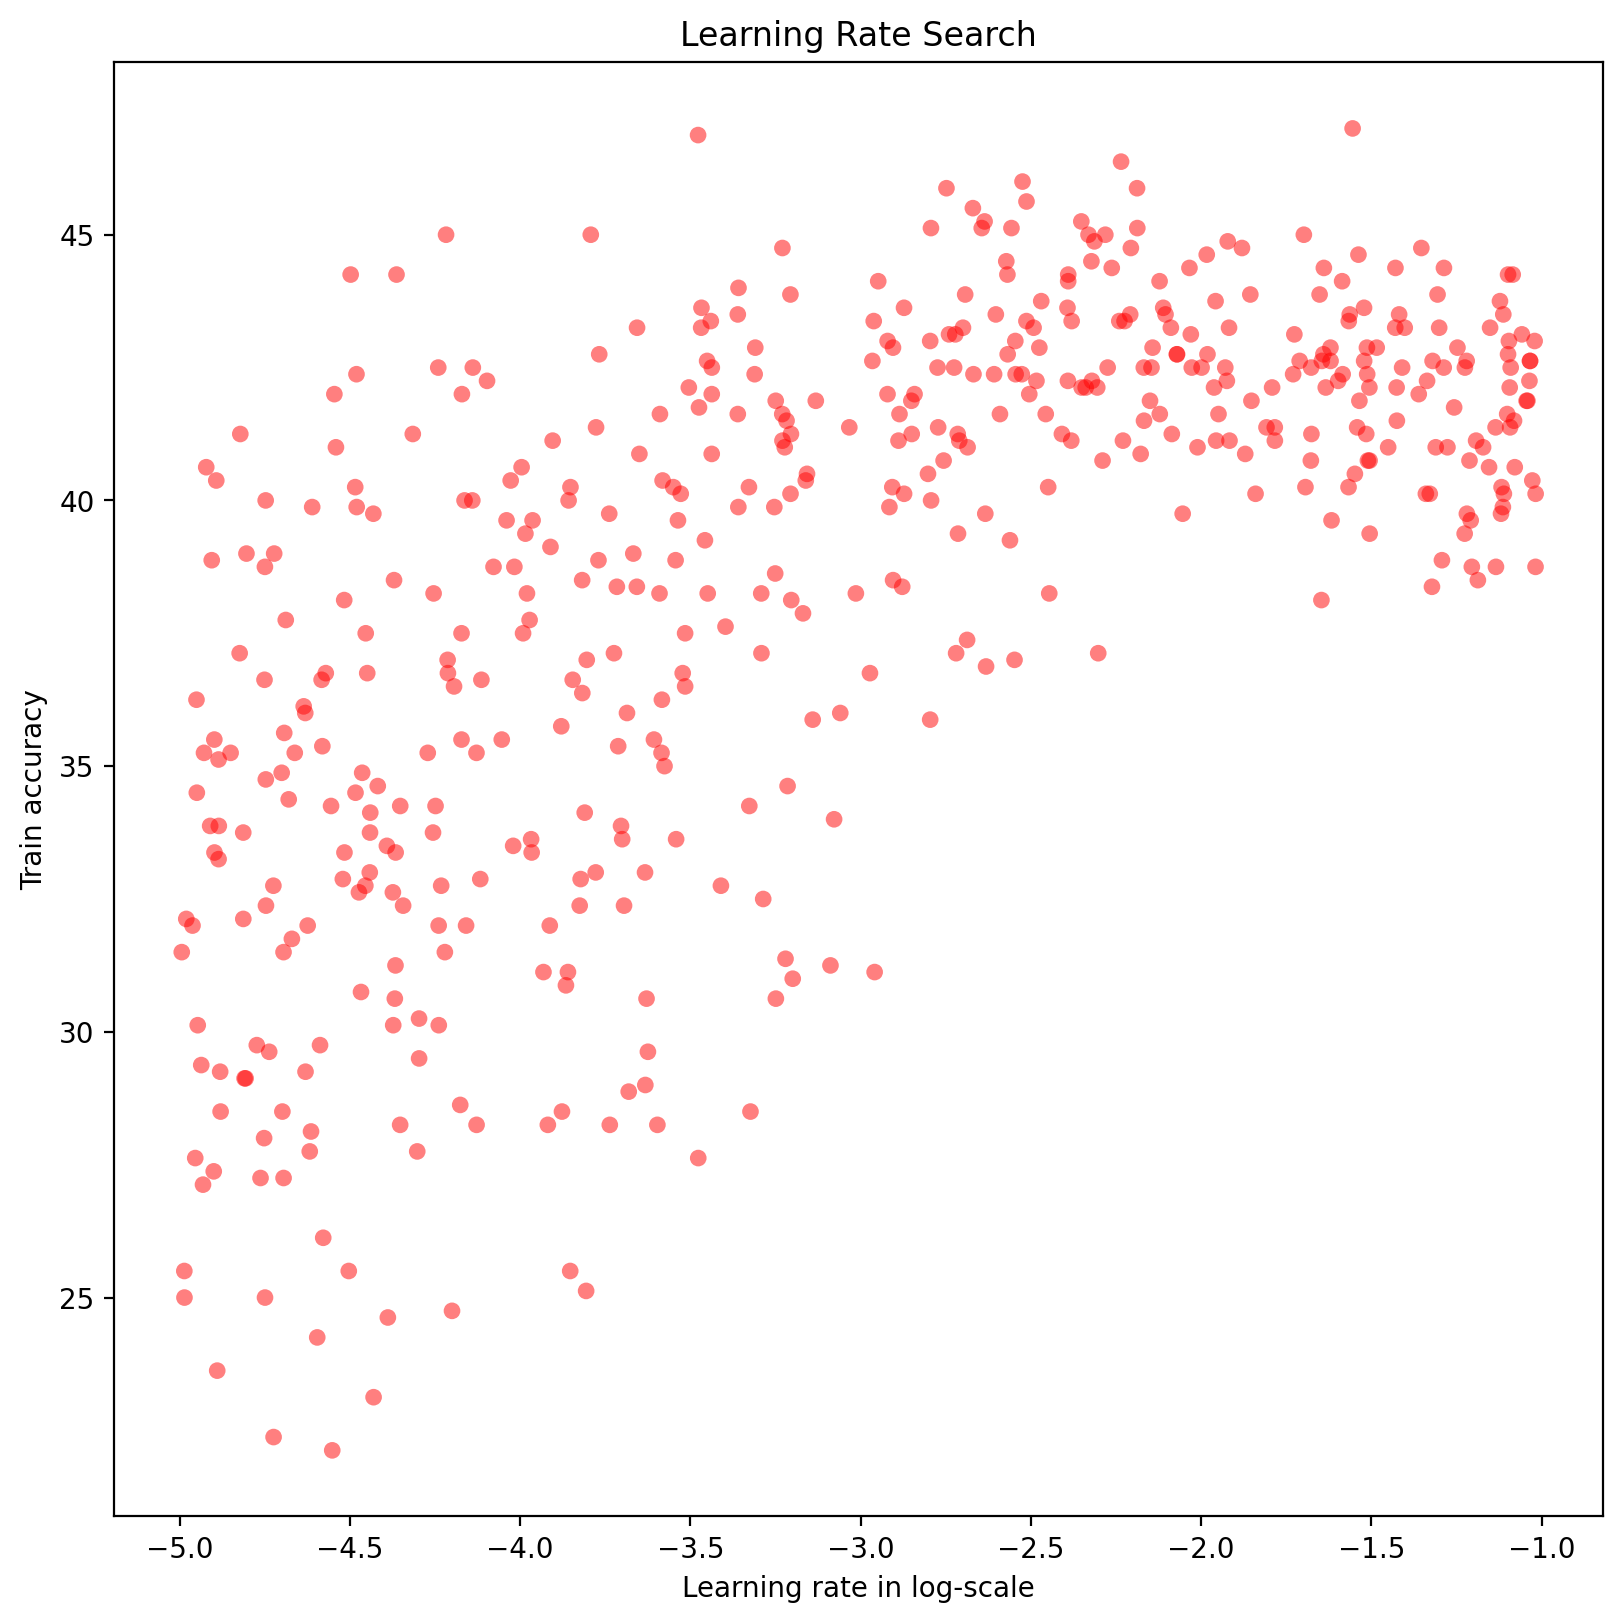

best_log_lr: -1.5552344044676665


In [35]:
record = learning_rate_search(model, 
                              min_log_lr=-4.5, 
                              max_log_lr=-1.4, 
                              trials=500, 
                              epochs=1)
draw_learning_rate_record(record)
best_log_lr = record[np.argmax(np.array([v for lr, v in record]))][0]

# best_log_lr = -2.0523682533344423
print('best_log_lr:', best_log_lr)

**************************************** Training Starts ****************************************


  0%|          | 0/500 [00:00<?, ?it/s]

------------------------------ Epoch 001 / 500, Learning rate: 2.78e-02 ------------------------------
- Iter 012 / 025, Loss: 1.128310
- Iter 024 / 025, Loss: 0.962970

* Train accuracy / confusion: 43.88% / [[280, 58, 17], [197, 60, 9], [123, 45, 11]], 
* Val   accuracy / confusion: 41.35% / [[26, 17, 3], [16, 15, 4], [16, 5, 2]]

------------------------------ Epoch 002 / 500, Learning rate: 2.78e-02 ------------------------------
- Iter 012 / 025, Loss: 1.096905
- Iter 024 / 025, Loss: 1.087977

* Train accuracy / confusion: 42.00% / [[256, 92, 10], [190, 73, 6], [110, 56, 7]], 
* Val   accuracy / confusion: 45.19% / [[39, 6, 1], [28, 7, 0], [21, 1, 1]]

------------------------------ Epoch 003 / 500, Learning rate: 2.78e-02 ------------------------------
- Iter 012 / 025, Loss: 1.045854
- Iter 024 / 025, Loss: 1.081240

* Train accuracy / confusion: 45.62% / [[254, 92, 6], [156, 105, 10], [82, 89, 6]], 
* Val   accuracy / confusion: 50.96% / [[40, 6, 0], [22, 13, 0], [18, 5, 0]]



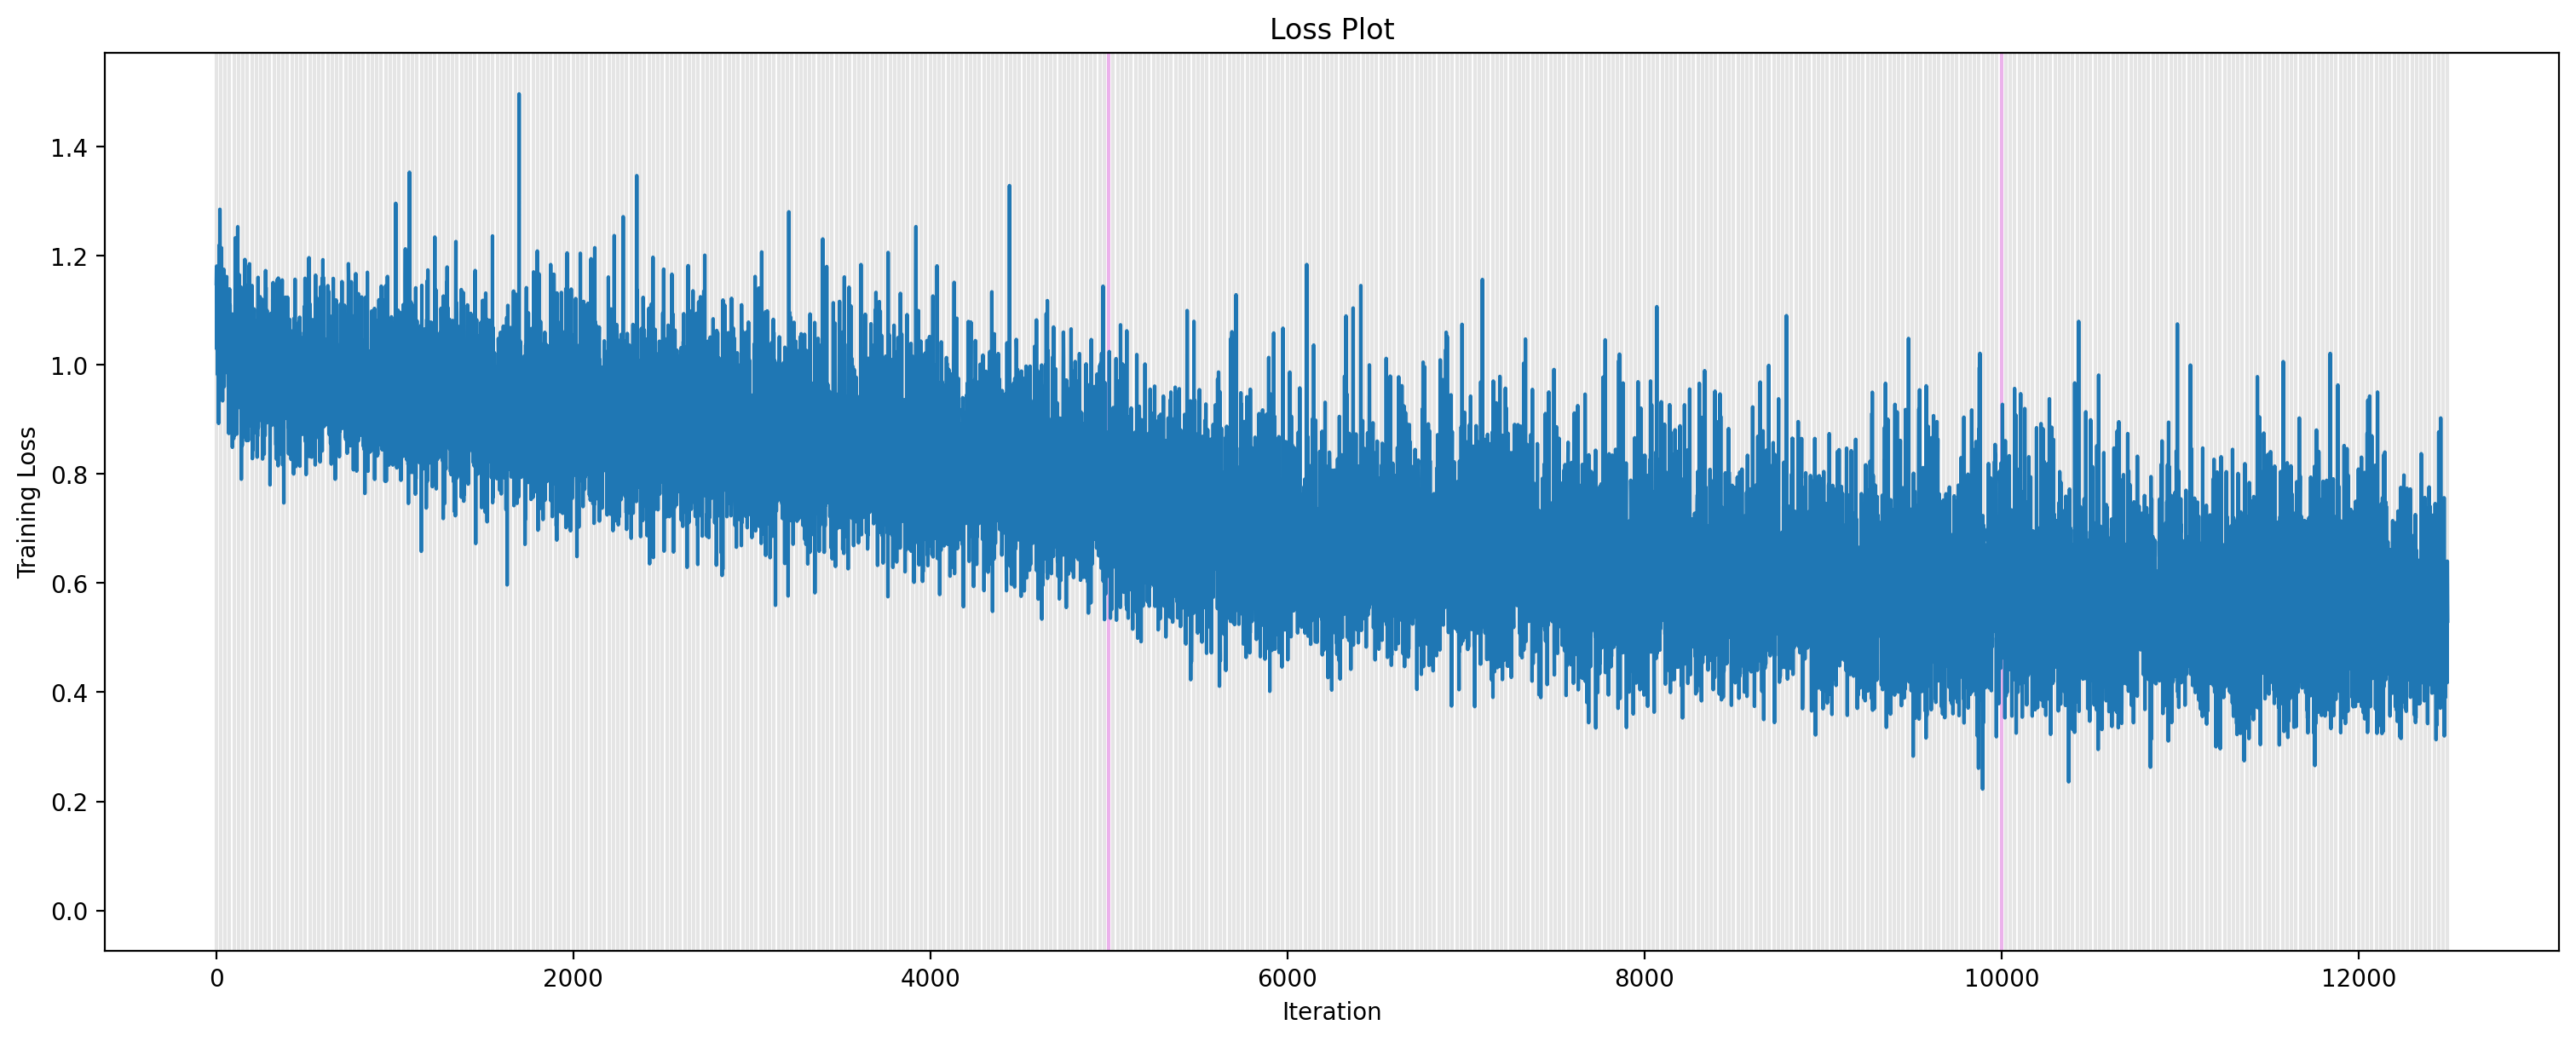

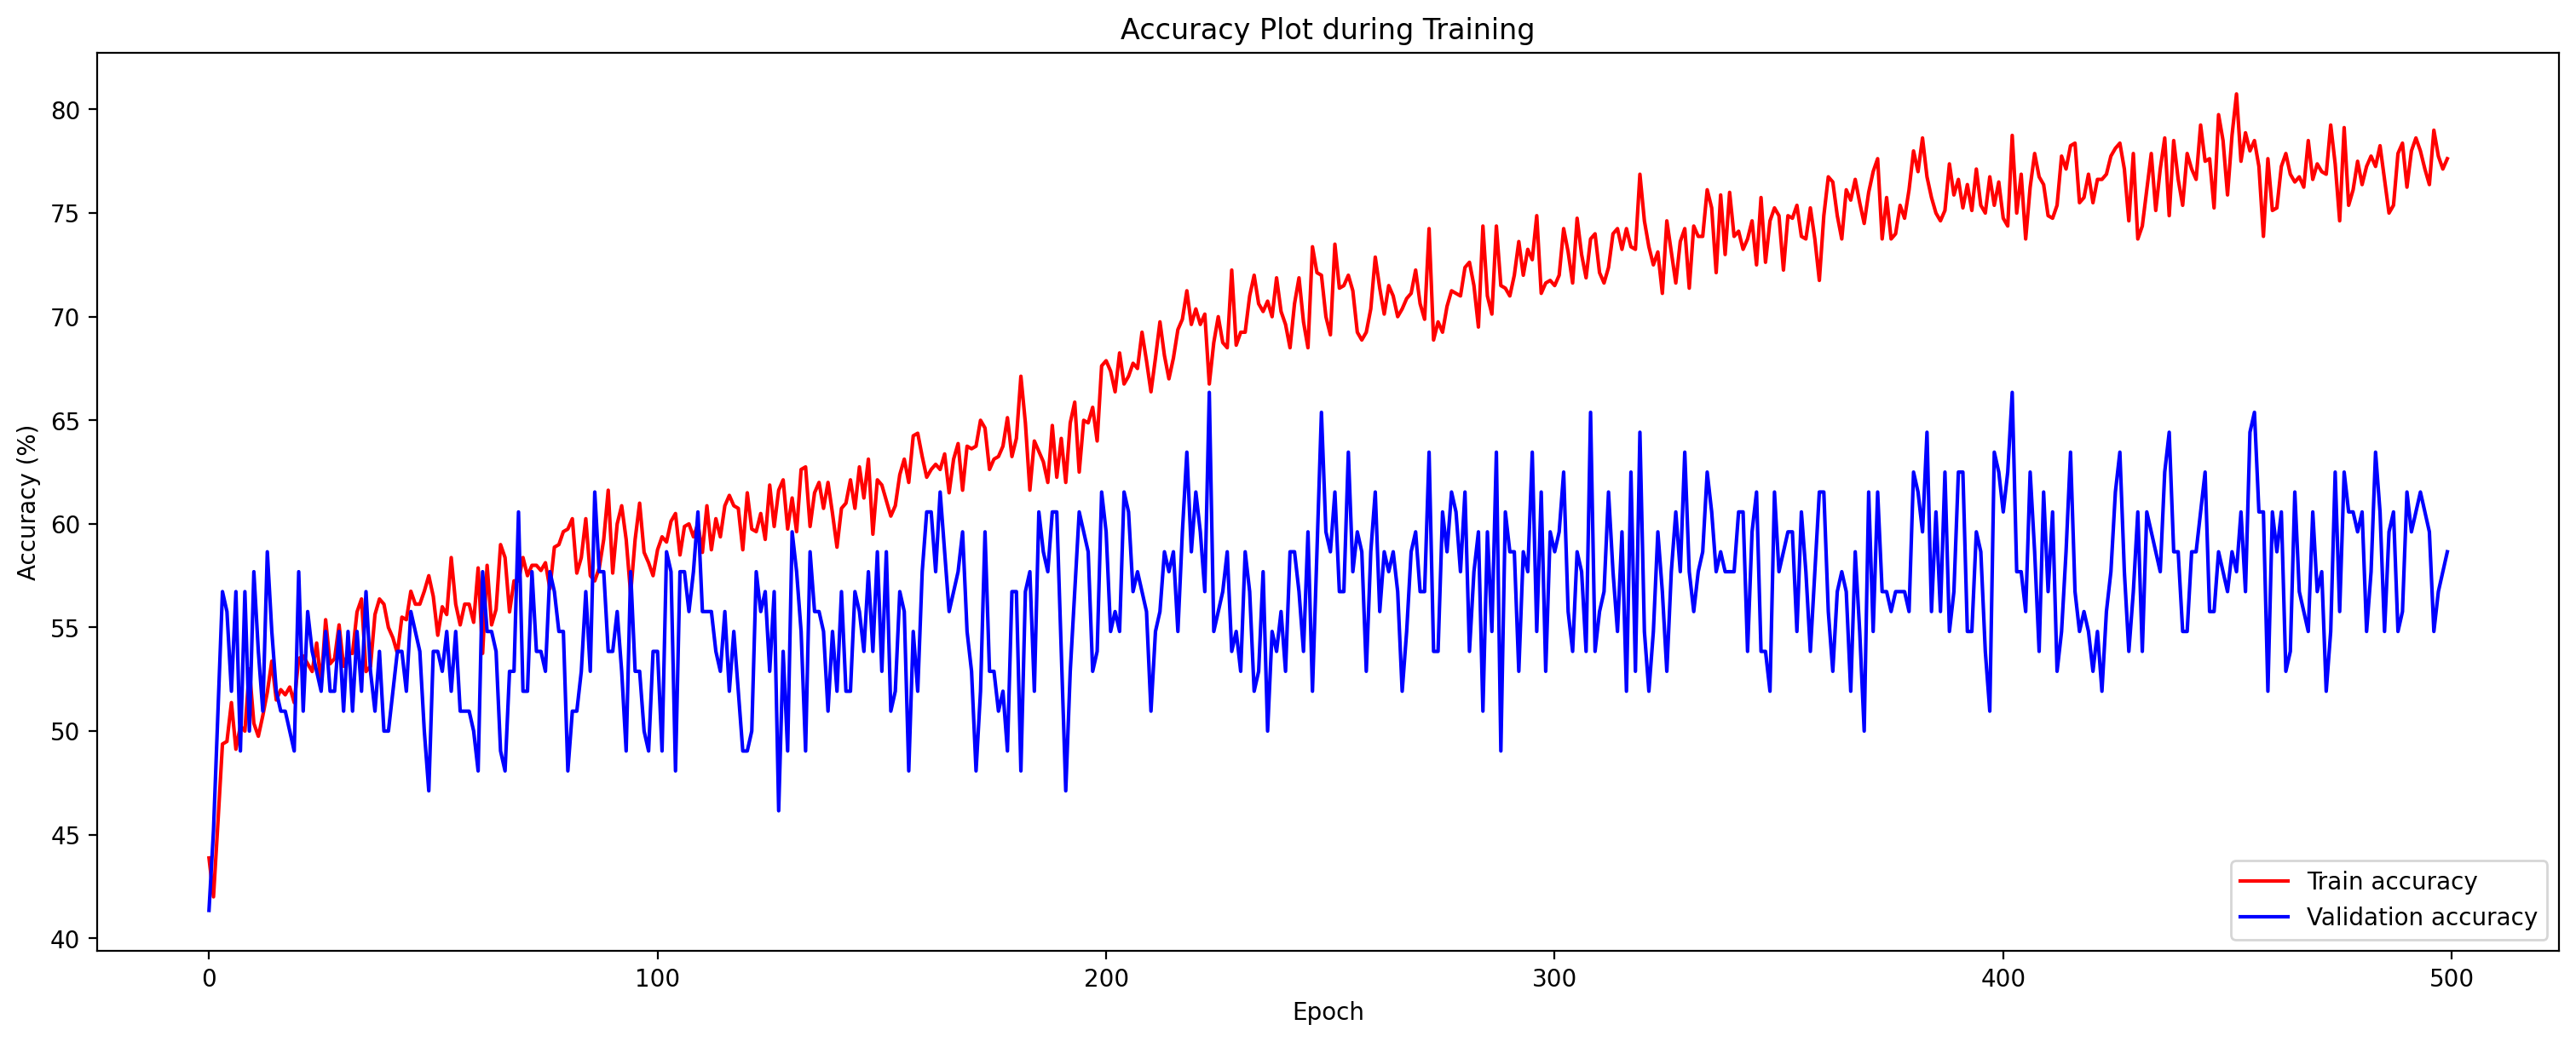

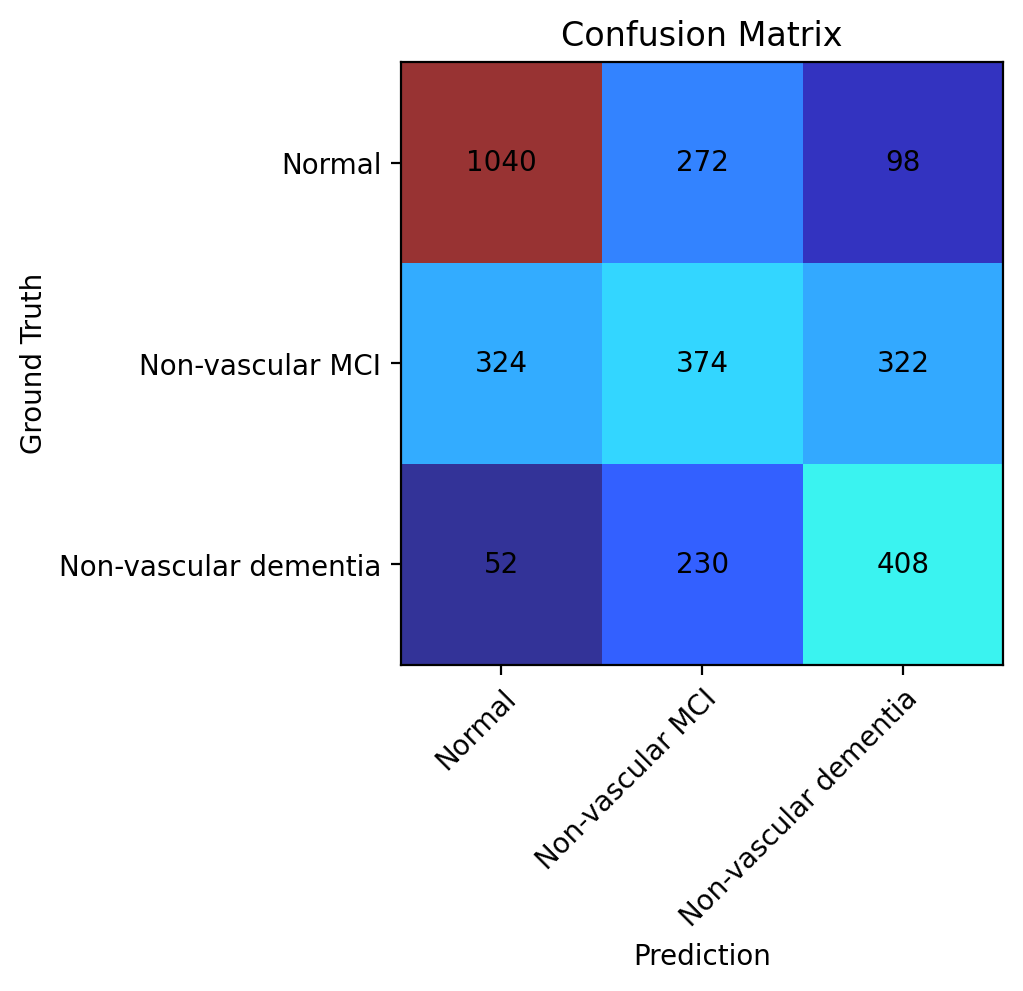

In [36]:
# reduce the learning after [lr_schedule_step] epochs by a factor of 10
n_epoch = 500
lr_schedule_step = 200
log_interval = len(train_loader) // 2

loss_history = []
train_acc_history = []
val_acc_history = []

model.reset_weights()
optimizer = optim.AdamW(model.parameters(), lr=10 ** best_log_lr, weight_decay=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=lr_schedule_step, gamma=0.1)

print(f'{"*"*40} Training Starts {"*"*40}')

for epoch in tqdm(range(1, n_epoch + 1)):
    print(f'{"-"*30} Epoch {epoch:03d} / {n_epoch:03d}, Learning rate: {optimizer.param_groups[-1]["lr"]:.2e} {"-"*30}')
    
    # train
    loss, train_accuracy, train_confusion = train_one_epoch(model, optimizer, log_interval)
    loss_history.extend(loss)
    train_acc_history.append(train_accuracy)
    
    # validation
    val_accuracy, val_confusion = check_val_accuracy(model)
    val_acc_history.append(val_accuracy)
    
    # learning rate schedule
    scheduler.step()
    
    print()
    print(f'* Train accuracy / confusion: {train_accuracy:.2f}% / {train_confusion.tolist()}, ')
    print(f'* Val   accuracy / confusion: {val_accuracy:.2f}% / {val_confusion.tolist()}')
    print()
    
# test
test_accuracy, test_confusion, test_debug = check_test_accuracy(model, repeat=30)

print(f'{"*"*40} Training Ends {"*"*40}')
print(f'- Test accuracy: {test_accuracy:.2f}%')
print()
print('- Confusion matrix:\n', test_confusion)
print()

# draw the training loss plot
draw_loss_plot(loss_history)
draw_accuracy_history(train_acc_history, val_acc_history)

# draw the confusion matrix
draw_confusion(test_confusion)

In [ ]:
print('- Debug table:')
pprint.pp(test_debug, indent=2, width=100)